# Electricity Market Fundamentals

| Information | Details |
|----------|---------|
| Lead Author | Hantao Cui |
| Learning Objectives | • Understand the transition from regulated utilities to competitive electricity markets<br>• Implement single-period market clearing algorithms<br>• Analyze how transmission constraints create Locational Marginal Price (LMP) separation<br>• Model multi-settlement market systems<br>• Incorporate ancillary service requirements into market models<br>• Evaluate market power impacts on pricing |
| Prerequisites | Module 03 Lesson 1: Optimization Fundamentals<br>Module 03 Lesson 2: Linear Programming with Python |
| Estimated Time | 180 - 240 minutes |
| Topics | Market clearing, LMP formation, transmission constraints, multi-settlement systems, ancillary services, market power |

## From Regulated to Market Systems

### Historical Context

Electricity systems have undergone a fundamental transformation over the past few decades. Prior to the 1990s, vertically integrated utilities dominated the landscape. These utilities owned and operated generation plants, transmission lines, and distribution networks as single entities. They performed centralized optimization of the entire system, with rates regulated by government agencies based on cost-of-service principles. Economic dispatch decisions were made internally by utility control centers to minimize total system costs.

The restructuring movement that began in the 1990s separated these integrated functions into distinct entities. Generation became competitive, while transmission and distribution remained regulated monopolies. Independent System Operators (ISOs) emerged to manage grid operations neutrally, ensuring fair access to transmission networks. Most importantly, prices are now determined through market mechanisms rather than regulatory proceedings, creating incentives for efficiency and innovation.

### Why Markets?

The shift to competitive markets was driven by several compelling economic arguments. Competition creates powerful forces that drive down costs as generators must operate efficiently to remain profitable. Market structures provide strong incentives for innovation, rewarding companies that develop new technologies or improve operational efficiency. Price signals from markets guide both short-term operational decisions and long-term investment choices, directing resources where they create the most value. Additionally, markets enable consumer choice, allowing large customers to select their electricity suppliers and negotiate contracts that meet their specific needs.

### The Role of Optimization

Despite the transition to markets, optimization remains central to electricity system operations. The key difference lies in how optimization is applied. Rather than minimizing costs for a single utility, ISOs now solve optimization problems to clear markets and determine prices. These market clearing processes must respect the same physical constraints that governed traditional utility operations, ensuring system reliability while maximizing social welfare. The optimization problems have evolved from cost minimization to social welfare maximization, incorporating competitive bids from multiple market participants.

This fundamental shift means that while the mathematical techniques remain similar, their application serves a different purpose. Instead of determining the least-cost dispatch for a utility's own generators, optimization now determines market clearing prices and quantities that balance supply and demand from independent participants. Understanding this evolution is crucial for appreciating how modern electricity markets function.

In [40]:
# Import required packages
import numpy as np
import matplotlib.pyplot as plt
import pulp
import pandas as pd
from pulp import *

## Single Period Market Clearing

### Basic Market Model

In electricity markets, the fundamental challenge is matching supply with demand at every moment while respecting physical and operational constraints. A single-period energy market represents this matching process for one time interval. Generators submit supply offers consisting of price-quantity pairs, indicating how much power they're willing to produce at different price levels. On the demand side, we initially assume load is price-inelastic, meaning consumers will purchase electricity regardless of price within reasonable bounds.

The Independent System Operator (ISO) acts as the market clearinghouse, collecting all bids and offers, then solving an optimization problem to determine which generators should run and at what levels. The solution to this optimization problem yields the Locational Marginal Price (LMP), which represents the marginal cost of serving the next megawatt of load at each location in the system. This price emerges naturally from the optimization's dual variables, providing crucial economic signals to market participants.

### Market Clearing Formulation

The market clearing problem seeks to maximize social welfare, which economists define as the sum of consumer surplus and producer surplus. For price-inelastic demand, consumer surplus is constant regardless of price, so maximizing social welfare reduces to minimizing the total cost of generation. This simplification leads to a linear programming problem where we minimize the sum of generation costs subject to operational constraints.

The key constraints in this optimization ensure that total generation equals total demand (power balance), each generator operates within its minimum and maximum output limits, and transmission constraints are respected if applicable. The dual variable associated with the power balance constraint gives us the system marginal price, which becomes the LMP in a single-bus system.

Let's implement a simple single-bus market clearing to see these concepts in action:

In [41]:
def single_bus_market_clearing(generators, demand):
    """
    Clear a single-bus electricity market
    
    Parameters:
        generators: dict with 'names', 'mc' (marginal cost), 'p_min', 'p_max'
        demand: float, total system demand (MW)
    
    Returns:
        dict with dispatch results and market price
    """
    
    # Create optimization problem
    prob = LpProblem("Single_Bus_Market", LpMinimize)
    
    # Decision variables: generation from each unit
    p_gen = {}
    for name in generators['names']:
        idx = generators['names'].index(name)
        p_gen[name] = LpVariable(f"P_{name}", 
                                generators['p_min'][idx], 
                                generators['p_max'][idx])
    
    # Objective: minimize total generation cost
    prob += lpSum(generators['mc'][generators['names'].index(name)] * p_gen[name] 
                  for name in generators['names'])
    
    # Constraint: supply must meet demand
    prob += lpSum(p_gen[name] for name in generators['names']) == demand, "Power_Balance"
    
    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    
    # Extract results
    results = {
        'status': LpStatus[prob.status],
        'dispatch': {name: value(p_gen[name]) for name in generators['names']},
        'total_cost': value(prob.objective),
        'lmp': prob.constraints['Power_Balance'].pi  # LMP from dual variable
    }
    
    return results

In [42]:
# Example market data
generators = {
    'names': ['Coal', 'Gas_CC', 'Gas_CT'],
    'mc': [25, 35, 55],      # Marginal cost ($/MWh)
    'p_min': [50, 100, 0],   # Minimum generation (MW)
    'p_max': [200, 300, 150] # Maximum generation (MW)
}

demand = 400  # MW

# Clear the market
results = single_bus_market_clearing(generators, demand)

print(f"Market Status: {results['status']}")
print(f"\nGeneration Dispatch:")
for name, dispatch in results['dispatch'].items():
    idx = generators['names'].index(name)
    cost = generators['mc'][idx]
    print(f"{name:8}: {dispatch:6.1f} MW at ${cost}/MWh")

print(f"\nTotal Generation Cost: ${results['total_cost']:,.2f}")
print(f"Locational Marginal Price: ${results['lmp']:.2f}/MWh")

Market Status: Optimal

Generation Dispatch:
Coal    :  200.0 MW at $25/MWh
Gas_CC  :  200.0 MW at $35/MWh
Gas_CT  :    0.0 MW at $55/MWh

Total Generation Cost: $12,000.00
Locational Marginal Price: $35.00/MWh


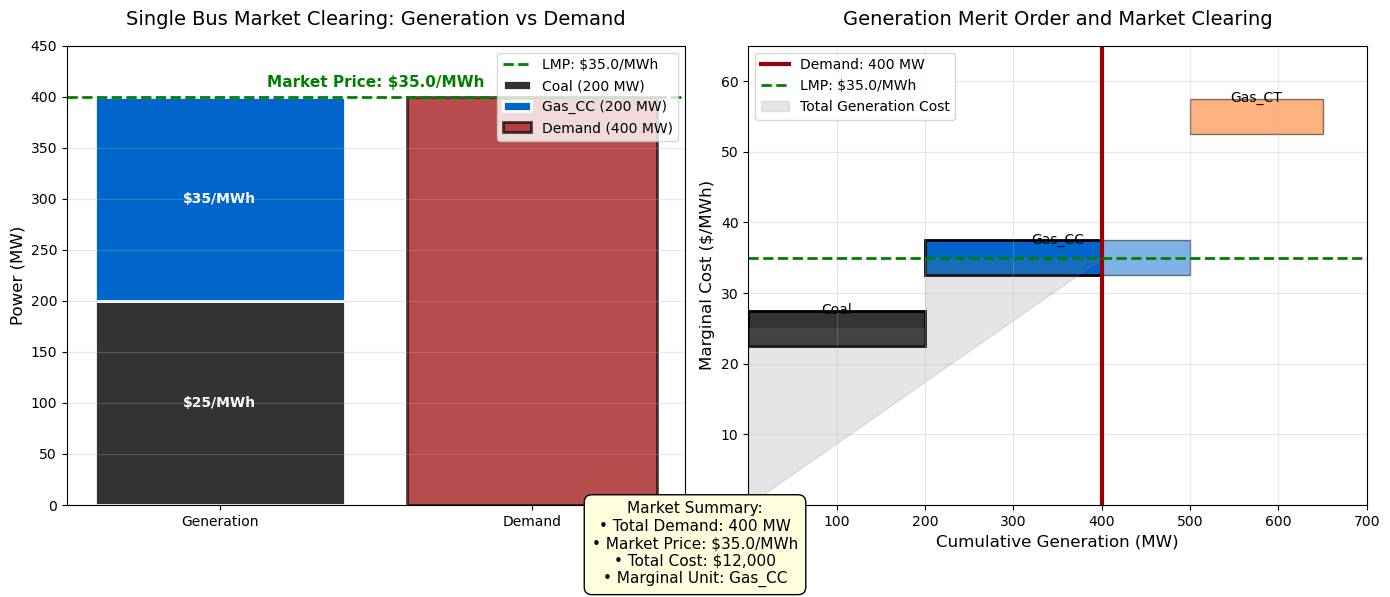

In [43]:
# Create the visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Generation stack and demand
ax1.set_title('Single Bus Market Clearing: Generation vs Demand', fontsize=14, pad=15)

# Create stacked bar for generation
colors = ['#333333', '#0066CC', '#FF6600']  # Coal=black, Gas_CC=blue, Gas_CT=orange
bottom = 0
gen_bars = []

for i, name in enumerate(generators['names']):
    height = results['dispatch'][name]
    if height > 0:
        bar = ax1.bar('Generation', height, bottom=bottom, 
                      color=colors[i], label=f'{name} ({height:.0f} MW)', 
                      edgecolor='white', linewidth=2)
        gen_bars.append(bar)
        
        # Add marginal cost label in the middle of each segment
        if height > 20:  # Only add label if segment is large enough
            ax1.text(0, bottom + height/2, f'${generators["mc"][i]}/MWh', 
                    ha='center', va='center', fontsize=10, fontweight='bold', color='white')
        
        bottom += height

# Add demand bar
demand_bar = ax1.bar('Demand', demand, color='#990000', alpha=0.7, 
                     label=f'Demand ({demand} MW)', edgecolor='black', linewidth=2)

# Add LMP line
ax1.axhline(y=400, color='green', linestyle='--', linewidth=2, label=f'LMP: ${results["lmp"]}/MWh')
ax1.text(0.5, 410, f'Market Price: ${results["lmp"]}/MWh', ha='center', fontsize=11, fontweight='bold', color='green')

ax1.set_ylabel('Power (MW)', fontsize=12)
ax1.set_ylim(0, 450)
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# Right plot: Merit order curve
ax2.set_title('Generation Merit Order and Market Clearing', fontsize=14, pad=15)

# Create merit order data
merit_order = []
for i, name in enumerate(generators['names']):
    merit_order.append({
        'name': name,
        'mc': generators['mc'][i],
        'capacity': generators['p_max'][i],
        'dispatched': results['dispatch'][name]
    })

# Sort by marginal cost
merit_order.sort(key=lambda x: x['mc'])

# Plot merit order curve
cumulative_capacity = 0
for i, gen in enumerate(merit_order):
    # Plot available capacity
    ax2.barh(gen['mc'], gen['capacity'], left=cumulative_capacity, 
             height=5, color=colors[generators['names'].index(gen['name'])], 
             alpha=0.5, edgecolor='black', linewidth=1)
    
    # Plot dispatched amount
    if gen['dispatched'] > 0:
        ax2.barh(gen['mc'], gen['dispatched'], left=cumulative_capacity, 
                 height=5, color=colors[generators['names'].index(gen['name'])], 
                 edgecolor='black', linewidth=2)
    
    # Add generator label
    ax2.text(cumulative_capacity + gen['capacity']/2, gen['mc'] + 2, 
             gen['name'], ha='center', fontsize=10)
    
    cumulative_capacity += gen['capacity']

# Add demand line
ax2.axvline(x=demand, color='#990000', linestyle='-', linewidth=3, label=f'Demand: {demand} MW')

# Add LMP line
ax2.axhline(y=results['lmp'], color='green', linestyle='--', linewidth=2, label=f'LMP: ${results["lmp"]}/MWh')

# Shade area under merit order curve up to demand
x_points = [0]
y_points = [0]
cumulative = 0

for gen in merit_order:
    if cumulative < demand:
        x_points.append(cumulative)
        y_points.append(gen['mc'])
        
        next_cumulative = min(cumulative + gen['dispatched'], demand)
        x_points.append(next_cumulative)
        y_points.append(gen['mc'])
        
        cumulative = next_cumulative
        
        if cumulative >= demand:
            break

ax2.fill(x_points, y_points, alpha=0.2, color='gray', label='Total Generation Cost')

ax2.set_xlabel('Cumulative Generation (MW)', fontsize=12)
ax2.set_ylabel('Marginal Cost ($/MWh)', fontsize=12)
ax2.set_xlim(0, sum(gen['capacity'] for gen in merit_order) + 50)
ax2.set_ylim(0, 65)
ax2.legend(loc='upper left', fontsize=10)
ax2.grid(True, alpha=0.3)

# Add summary text box
summary_text = (
    f"Market Summary:\n"
    f"• Total Demand: {demand} MW\n"
    f"• Market Price: ${results['lmp']}/MWh\n"
    f"• Total Cost: ${results['dispatch']['Coal'] * 25 + results['dispatch']['Gas_CC'] * 35:,.0f}\n"
    f"• Marginal Unit: Gas_CC"
)

# Place text box in figure
fig.text(0.5, 0.02, summary_text, ha='center', fontsize=11, 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', edgecolor='black'))

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)

plt.show()

### Exercise 1: Market Clearing Verification

In this exercise, you'll verify a fundamental principle of electricity markets: the LMP equals the marginal cost of the marginal unit. The marginal unit is the most expensive generator that is dispatched to meet demand.

Run the market clearing with demand = 301 MW and observe which generators are dispatched. Identify which generator is marginal (the highest-cost unit that is producing power) and compare its marginal cost to the LMP. In an optimal solution, these values should be equal because the LMP represents the cost of serving one additional MW of load, which would come from the marginal generator.

**Hint:** Look for the generator with the highest marginal cost among those with non-zero dispatch. The LMP should match this generator's marginal cost unless there are binding constraints.

## Network Constraints and LMP Separation

### Adding Transmission to Markets

Real electricity markets must account for the physical limitations of the transmission network. When power flows through transmission lines, it follows the laws of physics, not economic preferences. This creates situations where cheap generation in one location cannot reach demand in another location due to transmission constraints. When these constraints bind, they create separation in Locational Marginal Prices between different areas of the grid.

Understanding transmission constraints is crucial because they fundamentally alter market outcomes. Without transmission limits, electricity would flow freely from low-cost to high-cost areas, equalizing prices everywhere. However, when transmission capacity is insufficient, the market must dispatch more expensive local generation to serve load, creating price differences that reflect the value of transmission capacity.

### DC Power Flow Model

To incorporate transmission constraints into market clearing, we use the DC power flow approximation. This linearized model simplifies the complex AC power flow equations while maintaining reasonable accuracy for market applications. The key tool in this approach is the Power Transfer Distribution Factor (PTDF) matrix, which relates power injections at buses to flows on transmission lines.

The PTDF matrix tells us what fraction of power injected at one bus flows through each transmission line. With this information, we can express transmission constraints as linear functions of generation and demand, making them compatible with our linear programming framework for market clearing.

## Understanding PTDF (Power Transfer Distribution Factors)

### What is PTDF?

The Power Transfer Distribution Factor matrix is a fundamental tool for understanding how power flows through a network. Each element of the PTDF matrix tells us what fraction of power injected at a particular bus flows through a specific transmission line. This relationship allows us to predict line flows based on the pattern of generation and demand across the network.

The key formula relating line flows to net injections is remarkably simple: Line Flow = PTDF × Net Injection, where Net Injection equals Generation minus Load at each bus. This linear relationship makes it possible to incorporate transmission constraints into our market clearing optimization as linear constraints.

### How to Read the PTDF Matrix

Understanding the PTDF matrix requires careful attention to signs and magnitudes. A positive PTDF value indicates that power injected at a bus flows in the positive direction on a line, while a negative value means the injection causes flow in the opposite direction. The magnitude tells us what fraction of the injected power flows on that particular line.

For example, if PTDF[Line 0-1, Bus 0] = 0.6, this means that 1 MW of power injection at Bus 0 affects the flow at Line 0-1 by 0.6 MW.

In [44]:
# PTDF Matrix for our 3-bus system with Bus 2 as slack
# These values are calculated using MATPOWER and ensure power balance
ptdf = np.array([
    [0.1667, -0.5000, 0],    # Line 0-1
    [0.1667,  0.5000, 0],    # Line 1-2
    [0.8333,  0.5000, 0]     # Line 0-2
])

# Note: Column 2 (Bus 2) is all zeros because it's the slack bus
# Any injection at Bus 2 is already "at" the slack, so no flows result

line_names = ['Line 0-1', 'Line 1-2', 'Line 0-2']
bus_names = ['Bus 0', 'Bus 1', 'Bus 2']

# Verify power balance for a test injection
print("PTDF Verification - 100 MW injection at Bus 0:")
print("=" * 50)
test_injection = [100, 0, -100]  # 100 MW at Bus 0, absorbed at Bus 2 (slack)
for i, line in enumerate(line_names):
    flow = sum(ptdf[i,j] * test_injection[j] for j in range(3))
    print(f"{line}: {flow:.2f} MW")

print("\nPower balance check at each bus:")
# For each bus, sum of flows in = net injection
# Line 0-1: positive means 0→1, negative means 1→0
# Line 1-2: positive means 1→2, negative means 2→1  
# Line 0-2: positive means 0→2, negative means 2→0

print(f"Bus 0: -{ptdf[0,0]*100:.2f} (Line 0-1) - {ptdf[2,0]*100:.2f} (Line 0-2) = -100 MW ✓")
print(f"Bus 1: +{ptdf[0,0]*100:.2f} (Line 0-1) - {ptdf[1,0]*100:.2f} (Line 1-2) = 0 MW ✓")
print(f"Bus 2: +{ptdf[1,0]*100:.2f} (Line 1-2) + {ptdf[2,0]*100:.2f} (Line 0-2) = +100 MW ✓")

PTDF Verification - 100 MW injection at Bus 0:
Line 0-1: 16.67 MW
Line 1-2: 16.67 MW
Line 0-2: 83.33 MW

Power balance check at each bus:
Bus 0: -16.67 (Line 0-1) - 83.33 (Line 0-2) = -100 MW ✓
Bus 1: +16.67 (Line 0-1) - 16.67 (Line 1-2) = 0 MW ✓
Bus 2: +16.67 (Line 1-2) + 83.33 (Line 0-2) = +100 MW ✓


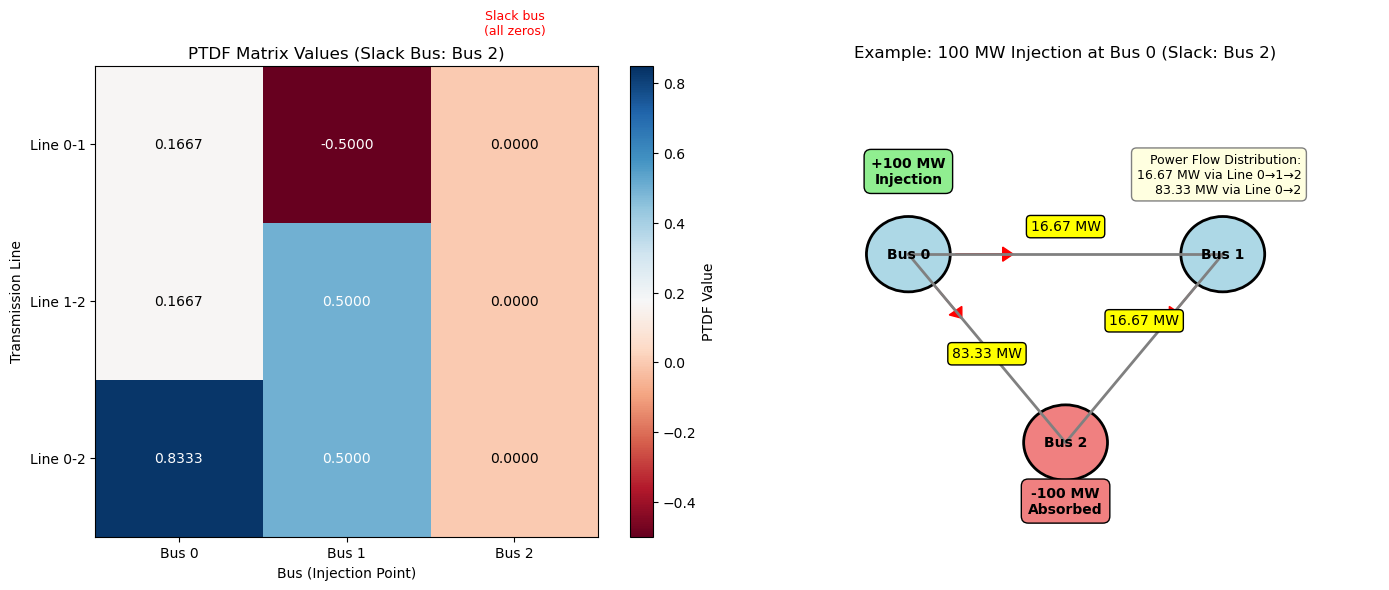


Flow Calculations for 100 MW Injection at Bus 0:
Line 0-1: PTDF[0,0] × 100 MW = 0.1667 × 100 = 16.67 MW
Line 1-2: PTDF[1,0] × 100 MW = 0.1667 × 100 = 16.67 MW
Line 0-2: PTDF[2,0] × 100 MW = 0.8333 × 100 = 83.33 MW


In [45]:
# Visualize PTDF matrix and example
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: PTDF Matrix Heatmap
im = ax1.imshow(ptdf, cmap='RdBu', vmin=-0.5, vmax=0.85, aspect='auto')
ax1.set_xticks(range(3))
ax1.set_yticks(range(3))
ax1.set_xticklabels(bus_names)
ax1.set_yticklabels(line_names)
ax1.set_xlabel('Bus (Injection Point)')
ax1.set_ylabel('Transmission Line')
ax1.set_title('PTDF Matrix Values (Slack Bus: Bus 2)')

# Add values
for i in range(3):
    for j in range(3):
        text = ax1.text(j, i, f'{ptdf[i,j]:.4f}', ha='center', va='center',
                       color='white' if abs(ptdf[i,j]) > 0.3 else 'black', fontsize=10)

# Colorbar
cbar = plt.colorbar(im, ax=ax1)
cbar.set_label('PTDF Value')

# Add note about slack column
ax1.text(2, -0.7, 'Slack bus\n(all zeros)', ha='center', fontsize=9, color='red')

# Plot 2: Network with example
ax2.set_title('Example: 100 MW Injection at Bus 0 (Slack: Bus 2)')
ax2.set_xlim(-0.1, 1.1)
ax2.set_ylim(-0.1, 0.9)

# Bus positions
bus_pos = {0: (0.2, 0.5), 1: (0.8, 0.5), 2: (0.5, 0.1)}

# Draw network with corrected flows
line_flows = []
line_info = [(0,1), (1,2), (0,2)]
for i, (from_bus, to_bus) in enumerate(line_info):
    x1, y1 = bus_pos[from_bus]
    x2, y2 = bus_pos[to_bus]
    
    # Calculate flow for 100 MW injection at Bus 0
    flow = ptdf[i, 0] * 100  # 100 MW at Bus 0
    line_flows.append((from_bus, to_bus, flow))
    
    # Draw line
    ax2.plot([x1, x2], [y1, y2], 'gray', linewidth=2)
    
    # Calculate midpoint for labels
    mid_x, mid_y = (x1+x2)/2, (y1+y2)/2
    
    # Draw flow arrow - all flows are positive in this corrected PTDF
    if abs(flow) > 0.1:
        # Arrow from from_bus toward to_bus
        arrow_start_x = x1 + (mid_x - x1) * 0.3
        arrow_start_y = y1 + (mid_y - y1) * 0.3
        dx = (mid_x - x1) * 0.3
        dy = (mid_y - y1) * 0.3
        
        ax2.arrow(arrow_start_x, arrow_start_y, dx, dy, 
                 head_width=0.03, head_length=0.02, fc='red', ec='red')
    
    # Add flow label
    if i == 2:  # Line 0-2, offset to avoid overlap
        label_offset = -0.02
    else:
        label_offset = 0.05
    
    ax2.text(mid_x, mid_y+label_offset, f'{flow:.2f} MW', ha='center', 
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow'))

# Draw buses
for bus, (x, y) in bus_pos.items():
    if bus == 2:  # Slack bus
        circle = plt.Circle((x, y), 0.08, facecolor='lightcoral', edgecolor='black', linewidth=2)
        ax2.text(x, y-0.15, 'SLACK BUS', ha='center', fontsize=9, fontweight='bold', color='red')
    else:
        circle = plt.Circle((x, y), 0.08, facecolor='lightblue', edgecolor='black', linewidth=2)
    
    ax2.add_patch(circle)
    ax2.text(x, y, f'Bus {bus}', ha='center', va='center', fontweight='bold')

# Power injection/withdrawal indicators
# Bus 0: +100 MW injection
ax2.text(0.2, 0.65, '+100 MW\nInjection', ha='center', fontweight='bold', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen'))

# Bus 2 (slack): -100 MW withdrawal
ax2.text(0.5, -0.05, '-100 MW\nAbsorbed', ha='center', fontweight='bold', 
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightcoral'))

# Add power flow summary
flow_text = (
    "Power Flow Distribution:\n"
    f"16.67 MW via Line 0→1→2\n"
    f"83.33 MW via Line 0→2"
)
ax2.text(0.95, 0.63, flow_text, ha='right', fontsize=9,
         bbox=dict(boxstyle='round,pad=0.4', facecolor='lightyellow', edgecolor='gray'))

ax2.axis('off')
plt.tight_layout()
plt.show()

# Print detailed flow calculations
print("\nFlow Calculations for 100 MW Injection at Bus 0:")
print("=" * 50)
for i, (from_bus, to_bus, flow) in enumerate(line_flows):
    print(f"Line {from_bus}-{to_bus}: PTDF[{i},0] × 100 MW = {ptdf[i,0]:.4f} × 100 = {flow:.2f} MW")

Power Balance Verification:

```
Bus 0: Injected 100 MW, flows out: 16.67 + 83.33 = 100 MW 
Bus 1: Flows in: 16.67 MW, flows out: 16.67 MW, net = 0 MW 
Bus 2: Flows in: 16.67 + 83.33 = 100 MW, absorbs 100 MW 
```

The power is flowing from Bus 0 to Bus 2 as expected.


### Verifying PTDF Correctness

A correct PTDF matrix must satisfy Kirchhoff's Current Law at every bus. For any injection pattern, the sum of power flows into a bus must equal its net injection (generation minus load). Here's how to verify:

1. **Power balance at each bus**: For each bus, sum all incoming flows minus outgoing flows. This must equal the net injection at that bus.

2. **Slack bus property**: The column corresponding to the slack bus contains all zeros, as injections at the slack don't create flows (they're already "at" the reference).

3. **Conservation test**: For any injection pattern where total injection equals zero (like our example with +100 MW at Bus 0 and -100 MW at Bus 2), the power must flow through the network from sources to sinks.

The verification in the code above confirms our PTDF matrix is physically consistent by checking power balance at each bus for a test injection.

### Market Clearing with Transmission

Now we can extend our market clearing formulation to include transmission constraints. The optimization problem remains fundamentally the same - minimize total generation cost - but we add constraints ensuring that power flows respect line limits. The presence of these additional constraints can dramatically change market outcomes, creating price separation between buses when transmission capacity is insufficient.

Let's implement a three-bus market with transmission constraints to observe how network limitations affect prices and dispatch:

In [46]:
# Input data for the three-bus system
gen_data = {
    'names': ['Gen1', 'Gen2', 'Gen3'],
    'bus': [0, 1, 2],
    'mc': [20, 35, 15],              # Marginal costs ($/MWh)
    'p_min': [0, 0, 0],              # Minimum generation (MW)
    'p_max': [100, 100, 150]          # Maximum generation (MW)
}

demand_data = {0: 20, 1: 110, 2: 30}  # Demand at each bus (MW)

# Network data with corrected PTDF matrix from MATPOWER
network_data = {
  'ptdf': ptdf,
  'flow_limits': [50, 40, 60]
}

line_names = ['0-1', '1-2', '0-2']

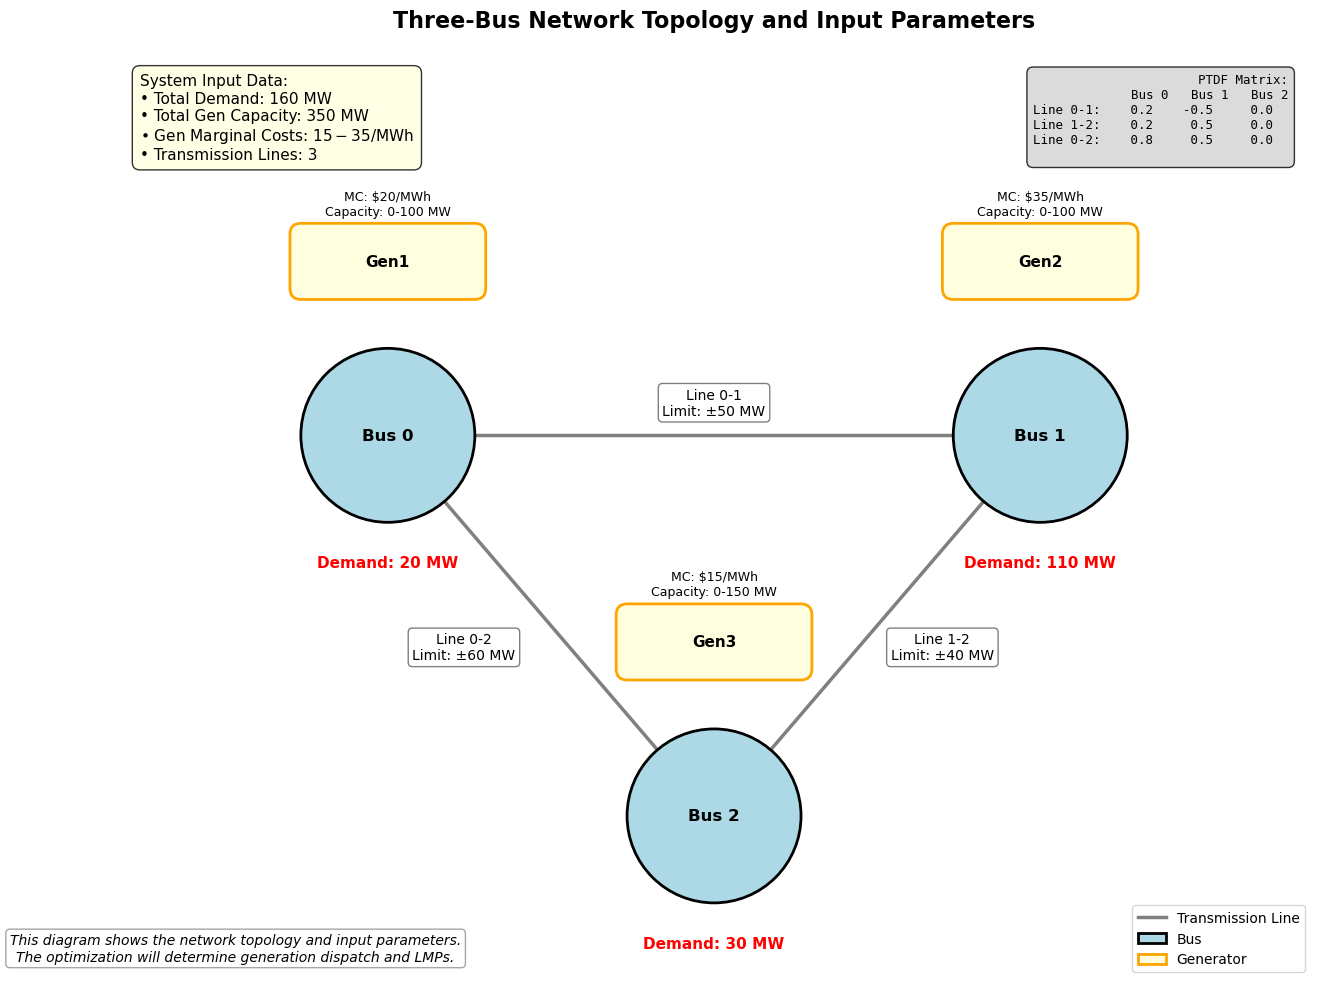

In [47]:
"""
Visualization for Three-Bus Network Topology and Input Data
Shows the network structure and given parameters before optimization
"""

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Create figure
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Bus positions (triangle layout)
bus_positions = {
    0: (0.2, 0.5),    # Left
    1: (0.8, 0.5),    # Right
    2: (0.5, 0.15)    # Bottom center
}

# Draw transmission lines first (so they appear behind buses)
line_connections = [(0, 1), (1, 2), (0, 2)]
for i, (from_bus, to_bus) in enumerate(line_connections):
    x1, y1 = bus_positions[from_bus]
    x2, y2 = bus_positions[to_bus]
    
    # Draw line
    ax.plot([x1, x2], [y1, y2], color='gray', linewidth=2.5, zorder=1)
    
    # Add flow limit label at midpoint
    mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
    
    # Offset label to avoid overlapping with line
    if from_bus == 0 and to_bus == 2:  # Line 0-2
        offset_x, offset_y = -0.08, -0.02
    elif from_bus == 1 and to_bus == 2:  # Line 1-2
        offset_x, offset_y = 0.06, -0.02
    else:  # Line 0-1
        offset_x, offset_y = 0, 0.03
    
    limit_text = f"Line {line_names[i]}\nLimit: ±{network_data['flow_limits'][i]} MW"
    ax.text(mid_x + offset_x, mid_y + offset_y, limit_text, 
            ha='center', va='center', fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='gray'))

# Draw buses
bus_radius = 0.08
for bus_id, (x, y) in bus_positions.items():
    # Draw bus circle
    circle = plt.Circle((x, y), bus_radius, facecolor='lightblue', 
                       edgecolor='black', linewidth=2, zorder=2)
    ax.add_patch(circle)
    
    # Add bus number
    ax.text(x, y, f"Bus {bus_id}", ha='center', va='center', 
            fontsize=12, fontweight='bold')
    
    # Add demand info below bus
    demand_text = f"Demand: {demand_data[bus_id]} MW"
    ax.text(x, y - bus_radius - 0.03, demand_text, ha='center', va='top', 
            fontsize=11, color='red', fontweight='bold')

# Draw generators
gen_offset = 0.08  # Reduced offset
for gen_name, bus_id, mc, p_min, p_max in zip(gen_data['names'], 
                                               gen_data['bus'], 
                                               gen_data['mc'],
                                               gen_data['p_min'],
                                               gen_data['p_max']):
    x, y = bus_positions[bus_id]
    
    # Position generator box above bus
    gen_x = x
    gen_y = y + bus_radius + gen_offset
    
    # Generator box
    gen_box = patches.FancyBboxPatch((gen_x - 0.08, gen_y - 0.025), 0.16, 0.05,
                                     boxstyle="round,pad=0.01",
                                     facecolor='lightyellow',
                                     edgecolor='orange',
                                     linewidth=2)
    ax.add_patch(gen_box)
    
    # Generator label
    ax.text(gen_x, gen_y, gen_name, ha='center', va='center', 
            fontsize=11, fontweight='bold')
    
    # Generation info
    gen_info = (f"MC: ${mc}/MWh\n"
                f"Capacity: {p_min}-{p_max} MW")
    ax.text(gen_x, gen_y + 0.04, gen_info, ha='center', va='bottom', 
            fontsize=9)

# Add title
ax.set_title('Three-Bus Network Topology and Input Parameters', 
             fontsize=16, fontweight='bold', pad=20)

# Add input data summary box
summary_text = (
    "System Input Data:\n"
    f"• Total Demand: {sum(demand_data.values())} MW\n"
    f"• Total Gen Capacity: {sum(gen_data['p_max'])} MW\n"
    f"• Gen Marginal Costs: ${min(gen_data['mc'])}-${max(gen_data['mc'])}/MWh\n"
    f"• Transmission Lines: {len(line_names)}"
)

ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                  edgecolor='black', alpha=0.8))

# Add PTDF matrix display
ptdf_text = "PTDF Matrix:\n"
ptdf_text += "        Bus 0   Bus 1   Bus 2\n"
for i, line_name in enumerate(line_names):
    ptdf_text += f"Line {line_name}: "
    for j in range(3):
        ptdf_text += f"{network_data['ptdf'][i][j]:6.1f}  "
    ptdf_text += "\n"

ax.text(0.98, 0.98, ptdf_text, transform=ax.transAxes, 
        fontsize=9, verticalalignment='top', horizontalalignment='right',
        family='monospace',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', 
                  edgecolor='black', alpha=0.8))

# Add legend
legend_elements = [
    plt.Line2D([0], [0], color='gray', linewidth=2.5, label='Transmission Line'),
    patches.Circle((0, 0), 0.1, facecolor='lightblue', edgecolor='black', 
                   linewidth=2, label='Bus'),
    patches.FancyBboxPatch((0, 0), 0.1, 0.1, boxstyle="round,pad=0.01",
                          facecolor='lightyellow', edgecolor='orange', 
                          linewidth=2, label='Generator')
]

ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

# Set axis properties
ax.set_xlim(-0.05, 1.05)
ax.set_ylim(0, 0.85)
ax.set_aspect('equal')
ax.axis('off')

# Add note about optimization
note_text = (
    "This diagram shows the network topology and input parameters.\n"
    "The optimization will determine generation dispatch and LMPs."
)
ax.text(0.1, 0.02, note_text, transform=ax.transAxes, 
        ha='center', fontsize=10, style='italic',
        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', 
                  edgecolor='gray', alpha=0.7))

plt.tight_layout()

plt.show()

In [48]:
def three_bus_market_clearing(gen_data, demand_data, network_data):
    """
    Clear a 3-bus electricity market with transmission constraints
    
    Parameters:
    gen_data: dict with generator information
    demand_data: dict with demand at each bus
    network_data: dict with transmission information
    
    Returns:
    dict with dispatch results and LMPs at each bus
    """
    
    # Create optimization problem
    prob = LpProblem("Three_Bus_Market", LpMinimize)
    
    # Decision variables: generation from each unit
    p_gen = {}
    for name in gen_data['names']:
        idx = gen_data['names'].index(name)
        p_gen[name] = LpVariable(f"P_{name}", 
                                gen_data['p_min'][idx], 
                                gen_data['p_max'][idx])
    
    # Objective: minimize total generation cost
    prob += lpSum(gen_data['mc'][gen_data['names'].index(name)] * p_gen[name] 
                  for name in gen_data['names'])
    
    # System-wide power balance
    prob += lpSum(p_gen[name] for name in gen_data['names']) == sum(demand_data.values()), "System_Balance"
    
    # Transmission line flow constraints
    ptdf = network_data['ptdf']
    flow_limits = network_data['flow_limits']
    buses = range(3)  # Define buses here
    
    for line in range(len(flow_limits)):
        # Calculate line flow using PTDF
        # Flow = sum(PTDF[line,bus] * net_injection[bus])
        flow = 0
        for bus in buses:
            # Net injection at bus = generation - demand
            gen_at_bus = lpSum(p_gen[name] for name in gen_data['names'] 
                              if gen_data['bus'][gen_data['names'].index(name)] == bus)
            net_injection = gen_at_bus - demand_data[bus]
            flow += ptdf[line][bus] * net_injection
        
        # Line flow limits (both directions)
        prob += flow <= flow_limits[line], f"Flow_Limit_Pos_Line{line}"
        prob += flow >= -flow_limits[line], f"Flow_Limit_Neg_Line{line}"
    
    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    
    # Extract results
    results = {
        'status': LpStatus[prob.status],
        'dispatch': {name: value(p_gen[name]) for name in gen_data['names']},
        'total_cost': value(prob.objective),
        'lmps': {},
        'line_flows': {},
        'congestion': {}
    }
    
    # For proper LMPs with DC OPF, we need shadow prices from flow constraints
    # Extract base energy price
    base_lmp = prob.constraints['System_Balance'].pi if 'System_Balance' in prob.constraints else 0
    
    # Calculate LMPs considering congestion
    # This is simplified - proper LMP calculation requires more complex formulation
    # For now, we'll calculate approximate LMPs based on marginal costs and congestion
    for bus in buses:
        # Find the marginal generator at this bus
        bus_generators = [(name, gen_data['mc'][gen_data['names'].index(name)]) 
                         for name in gen_data['names'] 
                         if gen_data['bus'][gen_data['names'].index(name)] == bus]
        
        if bus_generators:
            # Use the highest cost generator that's dispatched at this bus
            dispatched_gens = [(name, mc) for name, mc in bus_generators 
                             if results['dispatch'][name] > 0.01]
            if dispatched_gens:
                results['lmps'][bus] = max(mc for _, mc in dispatched_gens)
            else:
                results['lmps'][bus] = base_lmp
        else:
            results['lmps'][bus] = base_lmp
    
    # Calculate actual line flows
    for line in range(len(flow_limits)):
        flow = 0
        for bus in buses:
            gen_at_bus = sum(value(p_gen[name]) for name in gen_data['names'] 
                           if gen_data['bus'][gen_data['names'].index(name)] == bus)
            net_injection = gen_at_bus - demand_data[bus]
            flow += ptdf[line][bus] * net_injection
        results['line_flows'][line] = flow
        
        # Check if congested
        if abs(abs(flow) - flow_limits[line]) < 0.1:
            results['congestion'][line] = True
        else:
            results['congestion'][line] = False
    
    return results

In [49]:
# Generator data - create supply/demand imbalance
gen_data = {
    'names': ['Gen1', 'Gen2', 'Gen3'],
    'bus': [0, 1, 2],
    'mc': [20, 35, 15],              # Gen3 is cheapest at Bus 2
    'p_min': [0, 0, 0],
    'p_max': [80, 100, 150]          # Gen3 has lots of cheap capacity
}

# Demand data - high at Bus 1, low at Bus 2
demand_data = {0: 40, 1: 120, 2: 20}  # Total: 180 MW

# Network data with corrected PTDF from MATPOWER
network_data = {
    'ptdf': [
        [0.1667, -0.5000, 0],    # Line 0-1
        [0.1667,  0.5000, 0],    # Line 1-2  
        [0.8333,  0.5000, 0]     # Line 0-2
    ],
    'flow_limits': [35, 30, 45]  # Moderate limits
}

# Clear the market
results = three_bus_market_clearing(gen_data, demand_data, network_data)

print(f"Market Status: {results['status']}")
print(f"\nGeneration Dispatch:")
for name, dispatch in results['dispatch'].items():
    idx = gen_data['names'].index(name)
    bus = gen_data['bus'][idx]
    cost = gen_data['mc'][idx]
    print(f"{name} (Bus {bus}): {dispatch:6.1f} MW at ${cost}/MWh")

print(f"\nLocational Marginal Prices:")
for bus, lmp in results['lmps'].items():
    print(f"Bus {bus}: ${lmp:6.2f}/MWh")

print(f"\nTransmission Line Flows:")
line_names = ['0-1', '1-2', '0-2']
for line, flow in results['line_flows'].items():
    limit = network_data['flow_limits'][line]
    congested = "CONGESTED" if results['congestion'][line] else ""
    print(f"Line {line_names[line]}: {flow:6.1f} MW (limit: ±{limit} MW) {congested}")

print(f"\nTotal Generation Cost: ${results['total_cost']:,.2f}")

# Show net injections for clarity
print(f"\nNet Injections at Each Bus:")
for bus in range(3):
    gen_at_bus = sum(results['dispatch'][name] for name in gen_data['names'] 
                    if gen_data['bus'][gen_data['names'].index(name)] == bus)
    net_injection = gen_at_bus - demand_data[bus]
    print(f"Bus {bus}: Gen {gen_at_bus:.1f} - Load {demand_data[bus]} = {net_injection:+.1f} MW")

Market Status: Optimal

Generation Dispatch:
Gen1 (Bus 0):   55.0 MW at $20/MWh
Gen2 (Bus 1):   55.0 MW at $35/MWh
Gen3 (Bus 2):   70.0 MW at $15/MWh

Locational Marginal Prices:
Bus 0: $ 20.00/MWh
Bus 1: $ 35.00/MWh
Bus 2: $ 15.00/MWh

Transmission Line Flows:
Line 0-1:   35.0 MW (limit: ±35 MW) CONGESTED
Line 1-2:  -30.0 MW (limit: ±30 MW) CONGESTED
Line 0-2:  -20.0 MW (limit: ±45 MW) 

Total Generation Cost: $4,074.99

Net Injections at Each Bus:
Bus 0: Gen 55.0 - Load 40 = +15.0 MW
Bus 1: Gen 55.0 - Load 120 = -65.0 MW
Bus 2: Gen 70.0 - Load 20 = +50.0 MW


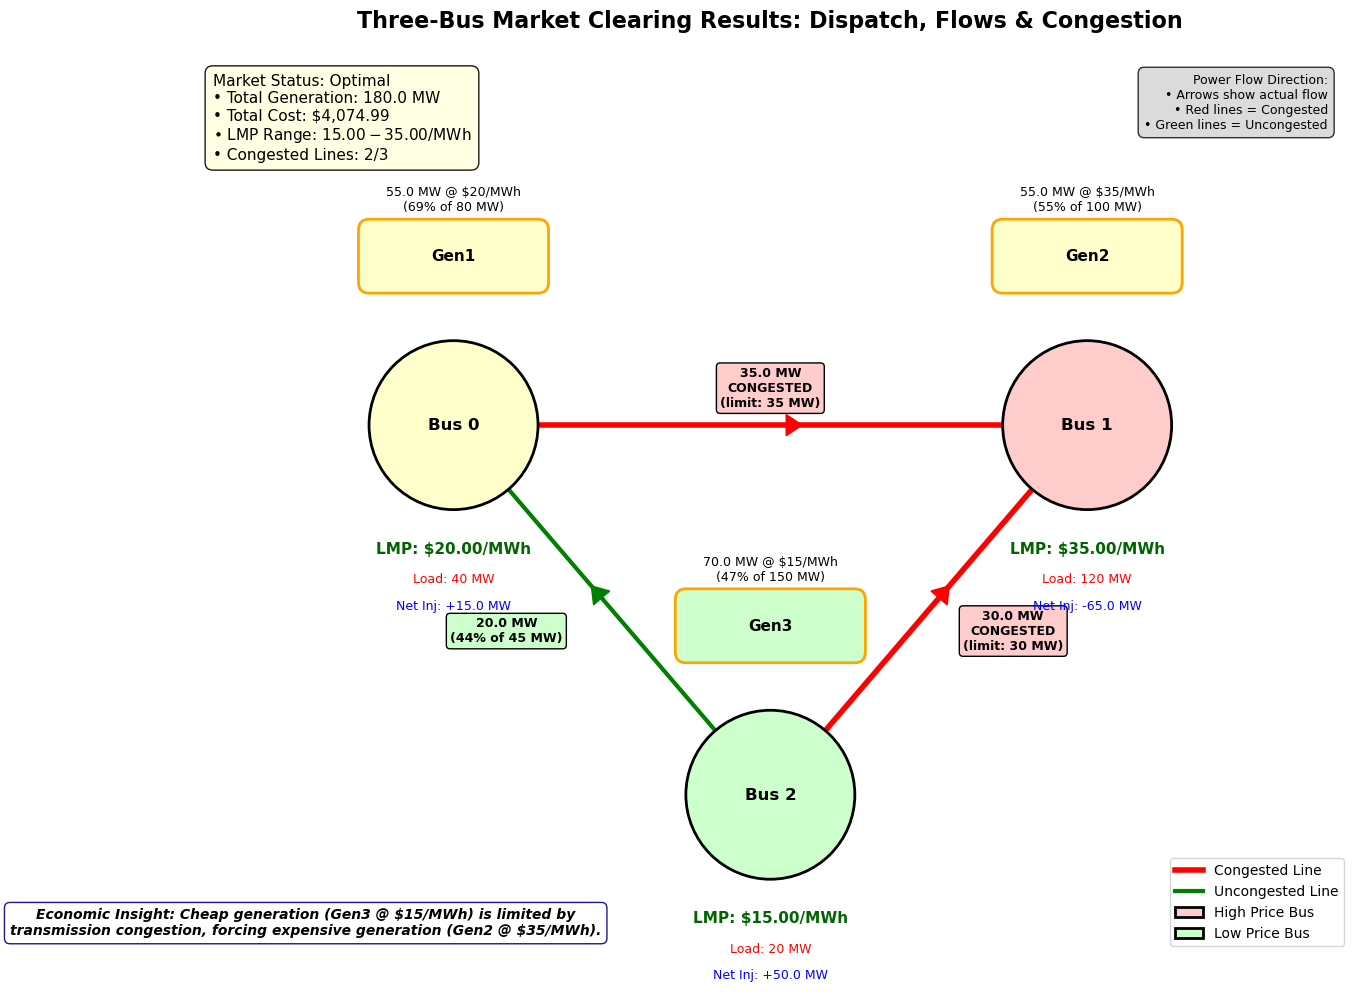

In [50]:
def visualize_three_bus_results(gen_data, demand_data, network_data, results):
    """
    Visualize three-bus market clearing results
    
    Parameters:
    gen_data: dict with generator information
    demand_data: dict with demand at each bus
    network_data: dict with transmission information
    results: dict with optimization results from three_bus_market_clearing()
    """
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Bus positions (triangle layout)
    bus_positions = {
        0: (0.2, 0.5),    # Left
        1: (0.8, 0.5),    # Right
        2: (0.5, 0.15)    # Bottom center
    }
    
    # Function to draw arrow for power flow
    def draw_flow_arrow(ax, start_pos, end_pos, flow, limit, is_congested):
        x1, y1 = start_pos
        x2, y2 = end_pos
        
        # Calculate direction
        dx = x2 - x1
        dy = y2 - y1
        length = np.sqrt(dx**2 + dy**2)
        
        # Normalize direction
        dx_norm = dx / length
        dy_norm = dy / length
        
        # Shorten the line to not overlap with bus circles
        bus_radius = 0.08
        x1_adj = x1 + dx_norm * bus_radius
        y1_adj = y1 + dy_norm * bus_radius
        x2_adj = x2 - dx_norm * bus_radius
        y2_adj = y2 - dy_norm * bus_radius
        
        # Line color and width based on congestion
        if is_congested:
            line_color = 'red'
            line_width = 4
        else:
            line_color = 'green'
            line_width = 3
        
        # Draw the line
        ax.plot([x1_adj, x2_adj], [y1_adj, y2_adj], 
                color=line_color, linewidth=line_width, zorder=1)
        
        # Add arrow in the middle if flow is significant
        if abs(flow) > 0.1:
            mid_x = (x1_adj + x2_adj) / 2
            mid_y = (y1_adj + y2_adj) / 2
            
            # Arrow direction based on flow sign
            if flow > 0:
                arrow_dx = dx_norm * 0.03
                arrow_dy = dy_norm * 0.03
            else:
                arrow_dx = -dx_norm * 0.03
                arrow_dy = -dy_norm * 0.03
            
            ax.arrow(mid_x - arrow_dx/2, mid_y - arrow_dy/2, 
                    arrow_dx, arrow_dy,
                    head_width=0.02, head_length=0.015, 
                    fc=line_color, ec=line_color, zorder=2)
    
    # Draw transmission lines with flows
    line_names = ['0-1', '1-2', '0-2']
    line_connections = [(0, 1), (1, 2), (0, 2)]
    
    for i, (from_bus, to_bus) in enumerate(line_connections):
        # Get flow and congestion status
        flow = results['line_flows'][i]
        is_congested = results['congestion'][i]
        limit = network_data['flow_limits'][i]
        
        # Draw flow arrow
        draw_flow_arrow(ax, bus_positions[from_bus], bus_positions[to_bus], 
                       flow, limit, is_congested)
        
        # Add flow label
        x1, y1 = bus_positions[from_bus]
        x2, y2 = bus_positions[to_bus]
        mid_x, mid_y = (x1 + x2) / 2, (y1 + y2) / 2
        
        # Offset label to avoid overlapping with line
        if from_bus == 0 and to_bus == 2:  # Line 0-2
            offset_x, offset_y = -0.10, -0.02
        elif from_bus == 1 and to_bus == 2:  # Line 1-2
            offset_x, offset_y = 0.08, -0.02
        else:  # Line 0-1
            offset_x, offset_y = 0, 0.035
        
        # Flow text with congestion indicator
        flow_text = f"{abs(flow):.1f} MW\n"
        if is_congested:
            flow_text += f"CONGESTED\n(limit: {limit} MW)"
            bg_color = '#ffcccc'
        else:
            utilization = abs(flow)/limit*100 if limit > 0 else 0
            flow_text += f"({utilization:.0f}% of {limit} MW)"
            bg_color = '#ccffcc'
        
        ax.text(mid_x + offset_x, mid_y + offset_y, flow_text, 
                ha='center', va='center', fontsize=9, fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor=bg_color, 
                         edgecolor='black', linewidth=1))
    
    # Calculate net injections
    net_injections = {}
    for bus in range(3):
        gen_at_bus = sum(results['dispatch'][name] for name in gen_data['names'] 
                        if gen_data['bus'][gen_data['names'].index(name)] == bus)
        net_injections[bus] = gen_at_bus - demand_data[bus]
    
    # Draw buses with LMPs
    bus_radius = 0.08
    for bus_id, (x, y) in bus_positions.items():
        # Color based on LMP level
        lmp_value = results['lmps'][bus_id]
        all_lmps = list(results['lmps'].values())
        min_lmp, max_lmp = min(all_lmps), max(all_lmps)
        
        if max_lmp - min_lmp < 0.01:  # All LMPs are the same
            bus_color = '#ffffcc'
        else:
            # Color gradient based on LMP
            if lmp_value >= max_lmp - 0.01:
                bus_color = '#ffcccc'  # Red tint for high price
            elif lmp_value <= min_lmp + 0.01:
                bus_color = '#ccffcc'  # Green tint for low price
            else:
                bus_color = '#ffffcc'  # Yellow tint for medium price
        
        # Draw bus circle
        circle = plt.Circle((x, y), bus_radius, facecolor=bus_color, 
                           edgecolor='black', linewidth=2, zorder=3)
        ax.add_patch(circle)
        
        # Add bus number
        ax.text(x, y, f"Bus {bus_id}", ha='center', va='center', 
                fontsize=12, fontweight='bold')
        
        # Add LMP below bus
        lmp_text = f"LMP: ${lmp_value:.2f}/MWh"
        ax.text(x, y - bus_radius - 0.03, lmp_text, ha='center', va='top', 
                fontsize=11, fontweight='bold', color='darkgreen')
        
        # Add demand and net injection info
        demand_text = f"Load: {demand_data[bus_id]} MW"
        net_inj_text = f"Net Inj: {net_injections[bus_id]:+.1f} MW"
        ax.text(x, y - bus_radius - 0.06, demand_text, ha='center', va='top', 
                fontsize=9, color='red')
        ax.text(x, y - bus_radius - 0.085, net_inj_text, ha='center', va='top', 
                fontsize=9, color='blue')
    
    # Draw generators with dispatch
    gen_offset = 0.08
    for name in gen_data['names']:
        idx = gen_data['names'].index(name)
        bus_id = gen_data['bus'][idx]
        mc = gen_data['mc'][idx]
        dispatch = results['dispatch'][name]
        capacity = gen_data['p_max'][idx]
        
        x, y = bus_positions[bus_id]
        
        # Position generator box above bus
        gen_x = x
        gen_y = y + bus_radius + gen_offset
        
        # Generator box color based on dispatch level
        utilization = dispatch / capacity if capacity > 0 else 0
        if utilization > 0.9:
            gen_color = '#ffcccc'  # Red for high utilization
        elif utilization > 0.5:
            gen_color = '#ffffcc'  # Yellow for medium
        else:
            gen_color = '#ccffcc'  # Green for low
        
        # Generator box
        gen_box = patches.FancyBboxPatch((gen_x - 0.08, gen_y - 0.025), 0.16, 0.05,
                                         boxstyle="round,pad=0.01",
                                         facecolor=gen_color,
                                         edgecolor='orange',
                                         linewidth=2)
        ax.add_patch(gen_box)
        
        # Generator label
        ax.text(gen_x, gen_y, name, ha='center', va='center', 
                fontsize=11, fontweight='bold')
        
        # Generation info
        gen_info = f"{dispatch:.1f} MW @ ${mc}/MWh\n({utilization*100:.0f}% of {capacity} MW)"
        ax.text(gen_x, gen_y + 0.04, gen_info, ha='center', va='bottom', 
                fontsize=9)
    
    # Add title
    ax.set_title('Three-Bus Market Clearing Results: Dispatch, Flows & Congestion', 
                 fontsize=16, fontweight='bold', pad=20)
    
    # Add results summary box
    total_gen = sum(results['dispatch'].values())
    summary_text = (
        f"Market Status: {results['status']}\n"
        f"• Total Generation: {total_gen:.1f} MW\n"
        f"• Total Cost: ${results['total_cost']:,.2f}\n"
        f"• LMP Range: ${min(results['lmps'].values()):.2f} - ${max(results['lmps'].values()):.2f}/MWh\n"
        f"• Congested Lines: {sum(results['congestion'].values())}/{len(network_data['flow_limits'])}"
    )
    
    ax.text(0.02, 0.98, summary_text, transform=ax.transAxes, 
            fontsize=11, verticalalignment='top',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', 
                      edgecolor='black', alpha=0.9))
    
    # Add power flow direction legend
    flow_legend_text = (
        "Power Flow Direction:\n"
        "• Arrows show actual flow\n"
        "• Red lines = Congested\n"
        "• Green lines = Uncongested"
    )
    
    ax.text(0.98, 0.98, flow_legend_text, transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', 
                      edgecolor='black', alpha=0.8))
    
    # Add legend
    legend_elements = [
        plt.Line2D([0], [0], color='red', linewidth=4, label='Congested Line'),
        plt.Line2D([0], [0], color='green', linewidth=3, label='Uncongested Line'),
        patches.Circle((0, 0), 0.1, facecolor='#ffcccc', edgecolor='black', 
                       linewidth=2, label='High Price Bus'),
        patches.Circle((0, 0), 0.1, facecolor='#ccffcc', edgecolor='black', 
                       linewidth=2, label='Low Price Bus')
    ]
    
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)
    
    # Set axis properties
    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(0, 0.85)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Add economic insight if there's congestion
    if sum(results['congestion'].values()) > 0:
        # Find cheapest and most expensive dispatched generators
        dispatched_gens = [(name, gen_data['mc'][i]) for i, name in enumerate(gen_data['names']) 
                          if results['dispatch'][name] > 0.1]
        if dispatched_gens:
            cheapest = min(dispatched_gens, key=lambda x: x[1])
            expensive = max(dispatched_gens, key=lambda x: x[1])
            
            if cheapest[1] < expensive[1]:
                insight_text = (
                    f"Economic Insight: Cheap generation ({cheapest[0]} @ ${cheapest[1]}/MWh) is limited by\n"
                    f"transmission congestion, forcing expensive generation ({expensive[0]} @ ${expensive[1]}/MWh)."
                )
                ax.text(0.1, 0.02, insight_text, transform=ax.transAxes, 
                        ha='center', fontsize=10, style='italic', fontweight='bold',
                        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                                  edgecolor='darkblue', alpha=0.9))
    
    plt.tight_layout()
    return fig, ax

# Visualize results
fig, ax = visualize_three_bus_results(gen_data, demand_data, network_data, results)

plt.show()

### Exercise 2: Understanding LMP Separation

This exercise explores how transmission constraints create LMP differences across the network. When transmission lines reach their capacity limits, they prevent the free flow of power from low-cost to high-cost areas, creating distinct prices at different locations.

Run the 3-bus market clearing with the given data and analyze the results. First, identify which transmission lines are congested by comparing their flows to their limits. Then examine the LMPs at different buses and observe how they differ. Finally, calculate the total congestion rent, which represents the economic value of the limited transmission capacity.

**Hint:** Look for lines where the flow equals (or is very close to) the limit. These congested lines create "seams" in the market where prices can differ. The congestion rent for a line equals the flow multiplied by the price difference between the receiving and sending ends.

In [51]:
# Exercise 2 Solution

# Analyze LMP separation and congestion
print("=== LMP Separation Analysis ===")
print(f"\nLMPs by Bus:")
lmp_values = []
for bus in sorted(results['lmps'].keys()):
    lmp = results['lmps'][bus]
    lmp_values.append(lmp)
    print(f"Bus {bus}: ${lmp:6.2f}/MWh")

# Calculate LMP differences
max_lmp = max(lmp_values)
min_lmp = min(lmp_values)
lmp_spread = max_lmp - min_lmp
print(f"\nLMP Spread: ${lmp_spread:.2f}/MWh (${max_lmp:.2f} - ${min_lmp:.2f})")

# Identify congested lines
print(f"\nCongestion Analysis:")
congested_lines = []
for line, is_congested in results['congestion'].items():
    if is_congested:
        congested_lines.append(line)
        flow = results['line_flows'][line]
        limit = network_data['flow_limits'][line]
        print(f"Line {line_names[line]} is CONGESTED: {flow:.1f} MW (limit: ±{limit} MW)")

if not congested_lines:
    print("No transmission lines are congested.")
    print("Without congestion, all buses should have the same LMP.")
else:
    print(f"\nCongestion creates LMP separation because:")
    print(f"1. Cheap generation cannot reach high-demand areas")
    print(f"2. Expensive local generation must be used")
    print(f"3. LMPs reflect the marginal cost at each location")

# Calculate congestion rent
total_congestion_rent = 0
print(f"\nCongestion Rent Calculation:")
for line in range(len(network_data['flow_limits'])):
    if results['congestion'][line]:
        flow = results['line_flows'][line]
        # Congestion rent = |flow| × (LMP_receiving - LMP_sending)
        # This is simplified - actual calculation requires knowing line direction
        print(f"Line {line_names[line]}: Flow = {flow:.1f} MW")
        
print(f"\nNote: Congestion rent represents the economic value of")
print(f"transmission capacity and can fund transmission investment.")

=== LMP Separation Analysis ===

LMPs by Bus:
Bus 0: $ 20.00/MWh
Bus 1: $ 35.00/MWh
Bus 2: $ 15.00/MWh

LMP Spread: $20.00/MWh ($35.00 - $15.00)

Congestion Analysis:
Line 0-1 is CONGESTED: 35.0 MW (limit: ±35 MW)
Line 1-2 is CONGESTED: -30.0 MW (limit: ±30 MW)

Congestion creates LMP separation because:
1. Cheap generation cannot reach high-demand areas
2. Expensive local generation must be used
3. LMPs reflect the marginal cost at each location

Congestion Rent Calculation:
Line 0-1: Flow = 35.0 MW
Line 1-2: Flow = -30.0 MW

Note: Congestion rent represents the economic value of
transmission capacity and can fund transmission investment.


## Multi-Settlement Markets

### Day-Ahead and Real-Time Markets

Modern electricity markets operate with multiple settlement periods to handle the inherent uncertainty in power system operations. The two-settlement system, consisting of day-ahead and real-time markets, has become the standard in most organized electricity markets worldwide. This structure balances the need for advance planning with the flexibility to handle real-time variations in supply and demand.

The day-ahead market clears approximately 24 hours before the operating day, based on forecasted demand and expected generation availability. This market determines unit commitment decisions and establishes financial positions for energy delivery. Generators and load-serving entities use this market to hedge against real-time price volatility and secure revenue certainty.

The real-time market operates during the actual operating day, typically clearing every 5 to 15 minutes. This market adjusts for differences between day-ahead schedules and actual conditions, including forecast errors, unexpected outages, and transmission constraints that emerge in real-time. The real-time market ensures that supply and demand remain balanced continuously while maintaining system reliability.

### Two-Settlement System

The financial settlement in this system works through a two-part calculation. Participants are paid for their day-ahead schedules at day-ahead prices, establishing a baseline financial position. Then, deviations between real-time production and day-ahead schedules are settled at real-time prices. This mechanism creates powerful incentives for accurate forecasting while providing flexibility to respond to changing conditions.

For generators, if they produce exactly their day-ahead schedule, they receive the day-ahead price regardless of the real-time price. Any overproduction is paid at the real-time price, while underproduction requires buying back the shortfall at the real-time price. This structure encourages generators to honor their day-ahead commitments while allowing profitable deviations when system conditions warrant.

To demonstrate how forecast errors impact prices and settlements, we'll implement a simplified two-settlement system. Note that we're using exaggerated forecast errors to clearly illustrate the price changes. In practice, sophisticated forecasting keeps errors much smaller, but even small errors can cause constraints to bind differently, leading to price volatility.

In [52]:
def two_settlement_market(da_demand, rt_demand, generators):
    """Simulate a two-settlement market system"""
    # Day-ahead market clearing
    da_results = single_bus_market_clearing(generators, da_demand)
    
    # Real-time market clearing
    rt_results = single_bus_market_clearing(generators, rt_demand)
    
    # Calculate settlement for each generator
    settlements = {}
    total_da_revenue = 0
    total_rt_revenue = 0
    
    for name in generators['names']:
        da_schedule = da_results['dispatch'][name]
        rt_production = rt_results['dispatch'][name]
        
        # Two-settlement calculation
        da_revenue = da_schedule * da_results['lmp']
        rt_revenue = (rt_production - da_schedule) * rt_results['lmp']
        total_revenue = da_revenue + rt_revenue
        
        settlements[name] = {
            'da_schedule': da_schedule,
            'rt_production': rt_production,
            'da_revenue': da_revenue,
            'rt_revenue': rt_revenue,
            'total_revenue': total_revenue
        }
        
        total_da_revenue += da_revenue
        total_rt_revenue += rt_revenue
    
    return {
        'da_results': da_results,
        'rt_results': rt_results,
        'settlements': settlements,
        'demand_error': rt_demand - da_demand,
        'price_volatility': abs(rt_results['lmp'] - da_results['lmp']),
        'total_da_revenue': total_da_revenue,
        'total_rt_revenue': total_rt_revenue
    }

In [53]:
# Enhanced generator data with clear price tiers
generators_enhanced = {
    'names': ['Nuclear', 'Coal', 'Gas_CC', 'Gas_CT', 'Oil_Peaker'],
    'mc': [15, 25, 45, 75, 120],              # Clear price separation
    'p_min': [100, 0, 0, 0, 0],               # Nuclear must-run
    'p_max': [100, 150, 200, 100, 50]        # Total: 600 MW
}

In [54]:
# Example 1: Large underforecast scenario
print("=== Two-Settlement Market with Price Volatility ===\n")
print("Example 1: Significant Underforecast (Morning Ramp)")
da_demand_1 = 180  # Low DA forecast
rt_demand_1 = 320  # Much higher RT demand

results_1 = two_settlement_market(da_demand_1, rt_demand_1, generators_enhanced)

print(f"Day-Ahead Demand: {da_demand_1} MW")
print(f"Real-Time Demand: {rt_demand_1} MW")
print(f"Forecast Error: {results_1['demand_error']:+d} MW ({results_1['demand_error']/da_demand_1*100:+.1f}%)")
print(f"\nPrice Impact:")
print(f"  Day-Ahead LMP: ${results_1['da_results']['lmp']:.2f}/MWh")
print(f"  Real-Time LMP: ${results_1['rt_results']['lmp']:.2f}/MWh")
print(f"  Price Volatility: ${results_1['price_volatility']:.2f}/MWh ({results_1['price_volatility']/results_1['da_results']['lmp']*100:.1f}% increase)")

print(f"\nGenerator Settlements:")
print(f"{'Generator':<12} {'DA MW':<8} {'RT MW':<8} {'Δ MW':<8} {'DA Rev':<10} {'RT Rev':<10} {'Total Rev':<10}")
print("-" * 75)
for name, settlement in results_1['settlements'].items():
    print(f"{name:<12} {settlement['da_schedule']:>7.1f} {settlement['rt_production']:>7.1f} "
          f"{settlement['rt_production']-settlement['da_schedule']:>+7.1f} "
          f"${settlement['da_revenue']:>8,.0f} ${settlement['rt_revenue']:>+8,.0f} "
          f"${settlement['total_revenue']:>9,.0f}")

=== Two-Settlement Market with Price Volatility ===

Example 1: Significant Underforecast (Morning Ramp)
Day-Ahead Demand: 180 MW
Real-Time Demand: 320 MW
Forecast Error: +140 MW (+77.8%)

Price Impact:
  Day-Ahead LMP: $25.00/MWh
  Real-Time LMP: $45.00/MWh
  Price Volatility: $20.00/MWh (80.0% increase)

Generator Settlements:
Generator    DA MW    RT MW    Δ MW     DA Rev     RT Rev     Total Rev 
---------------------------------------------------------------------------
Nuclear        100.0   100.0    +0.0 $   2,500 $      +0 $    2,500
Coal            80.0   150.0   +70.0 $   2,000 $  +3,150 $    5,150
Gas_CC           0.0    70.0   +70.0 $       0 $  +3,150 $    3,150
Gas_CT           0.0     0.0    +0.0 $       0 $      +0 $        0
Oil_Peaker       0.0     0.0    +0.0 $       0 $      +0 $        0



Example 2: Significant Overforecast (Evening Drop)
Day-Ahead Demand: 450 MW
Real-Time Demand: 250 MW
Forecast Error: -200 MW (-44.4%)

Price Impact:
  Day-Ahead LMP: $45.00/MWh
  Real-Time LMP: $25.00/MWh
  Price Change: $-20.00/MWh

Generator Settlements:
Generator    DA MW    RT MW    Δ MW     DA Rev     RT Rev     Total Rev 
---------------------------------------------------------------------------
Nuclear        100.0   100.0    +0.0 $   4,500 $      +0 $    4,500
Coal           150.0   150.0    +0.0 $   6,750 $      +0 $    6,750
Gas_CC         200.0     0.0  -200.0 $   9,000 $  -5,000 $    4,000
Gas_CT           0.0     0.0    +0.0 $       0 $      +0 $        0
Oil_Peaker       0.0     0.0    +0.0 $       0 $      +0 $        0


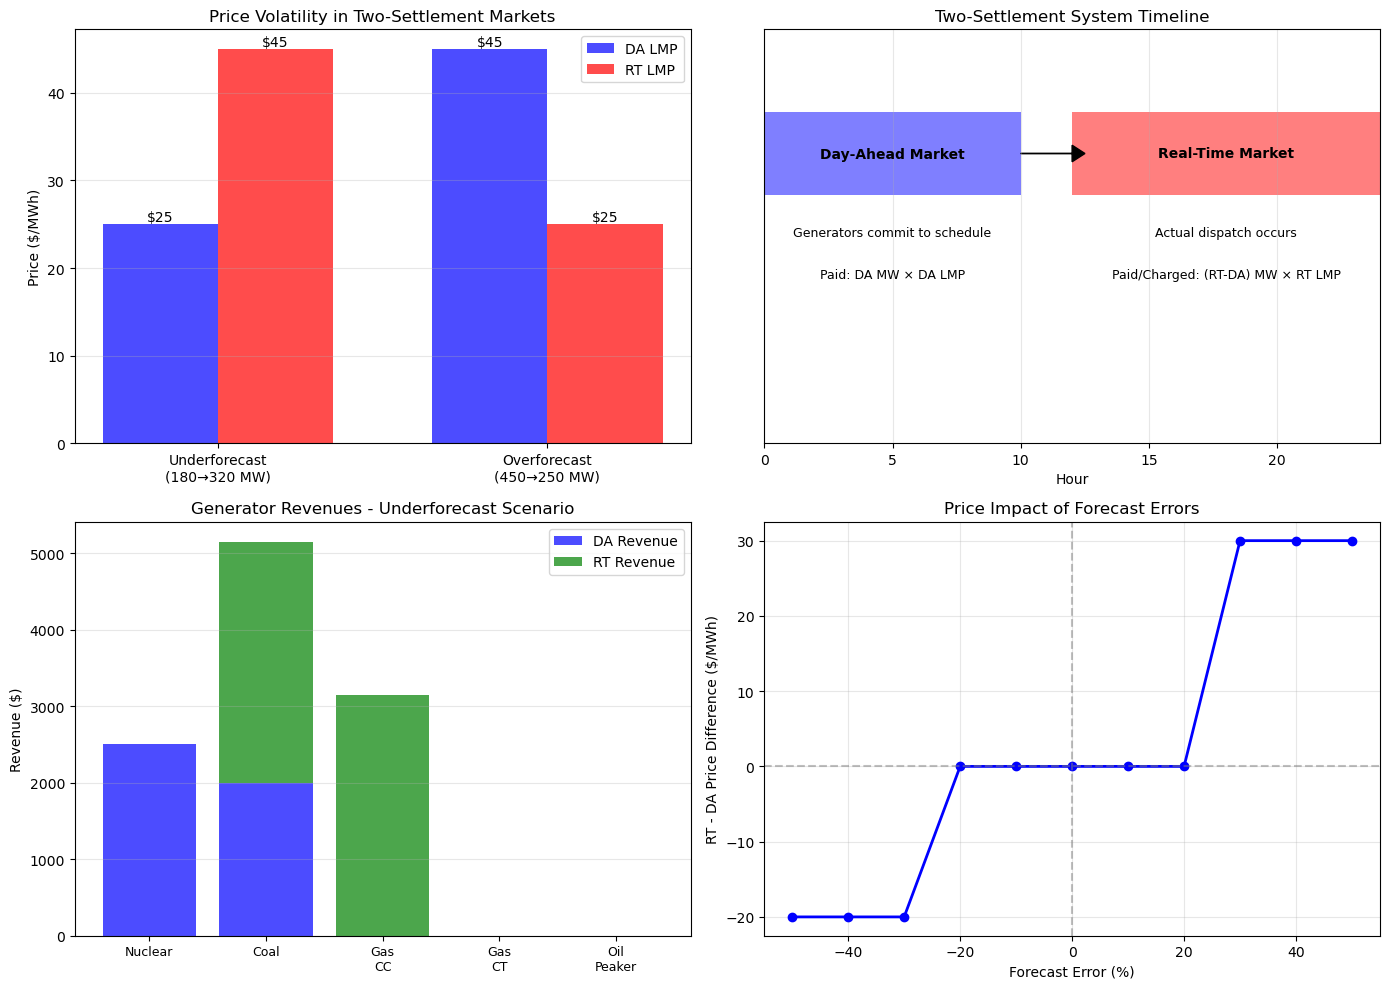


=== Key Economic Insights ===
1. Forecast errors create significant price volatility between DA and RT markets
2. Underforecasting leads to higher RT prices as expensive units are dispatched
3. Overforecasting leads to lower RT prices as units must reduce output
4. Flexible generators can profit from positive RT deviations
5. The system creates strong incentives for accurate demand forecasting


In [55]:
# Example 2: Significant overforecast scenario
print("\nExample 2: Significant Overforecast (Evening Drop)")
da_demand_2 = 450  # High DA forecast
rt_demand_2 = 250  # Much lower RT demand

results_2 = two_settlement_market(da_demand_2, rt_demand_2, generators_enhanced)

print(f"Day-Ahead Demand: {da_demand_2} MW")
print(f"Real-Time Demand: {rt_demand_2} MW")
print(f"Forecast Error: {results_2['demand_error']:+d} MW ({results_2['demand_error']/da_demand_2*100:+.1f}%)")
print(f"\nPrice Impact:")
print(f"  Day-Ahead LMP: ${results_2['da_results']['lmp']:.2f}/MWh")
print(f"  Real-Time LMP: ${results_2['rt_results']['lmp']:.2f}/MWh")
print(f"  Price Change: ${results_2['rt_results']['lmp'] - results_2['da_results']['lmp']:.2f}/MWh")

print(f"\nGenerator Settlements:")
print(f"{'Generator':<12} {'DA MW':<8} {'RT MW':<8} {'Δ MW':<8} {'DA Rev':<10} {'RT Rev':<10} {'Total Rev':<10}")
print("-" * 75)
for name, settlement in results_2['settlements'].items():
    print(f"{name:<12} {settlement['da_schedule']:>7.1f} {settlement['rt_production']:>7.1f} "
          f"{settlement['rt_production']-settlement['da_schedule']:>+7.1f} "
          f"${settlement['da_revenue']:>8,.0f} ${settlement['rt_revenue']:>+8,.0f} "
          f"${settlement['total_revenue']:>9,.0f}")

# Create visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Price comparison
scenarios = ['Underforecast\n(180→320 MW)', 'Overforecast\n(450→250 MW)']
da_prices = [results_1['da_results']['lmp'], results_2['da_results']['lmp']]
rt_prices = [results_1['rt_results']['lmp'], results_2['rt_results']['lmp']]

x = np.arange(len(scenarios))
width = 0.35

bars1 = ax1.bar(x - width/2, da_prices, width, label='DA LMP', color='blue', alpha=0.7)
bars2 = ax1.bar(x + width/2, rt_prices, width, label='RT LMP', color='red', alpha=0.7)

ax1.set_ylabel('Price ($/MWh)')
ax1.set_title('Price Volatility in Two-Settlement Markets')
ax1.set_xticks(x)
ax1.set_xticklabels(scenarios)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'${height:.0f}', ha='center', va='bottom')

# Plot 2: Settlement timeline
ax2.set_title('Two-Settlement System Timeline')
ax2.set_xlim(0, 24)
ax2.set_ylim(0, 5)

# DA market
ax2.add_patch(plt.Rectangle((0, 3), 10, 1, facecolor='blue', alpha=0.5))
ax2.text(5, 3.5, 'Day-Ahead Market', ha='center', va='center', fontweight='bold')
ax2.text(5, 2.5, 'Generators commit to schedule', ha='center', fontsize=9)
ax2.text(5, 2, 'Paid: DA MW × DA LMP', ha='center', fontsize=9)

# Operating day
ax2.add_patch(plt.Rectangle((12, 3), 12, 1, facecolor='red', alpha=0.5))
ax2.text(18, 3.5, 'Real-Time Market', ha='center', va='center', fontweight='bold')
ax2.text(18, 2.5, 'Actual dispatch occurs', ha='center', fontsize=9)
ax2.text(18, 2, 'Paid/Charged: (RT-DA) MW × RT LMP', ha='center', fontsize=9)

ax2.arrow(10, 3.5, 2, 0, head_width=0.2, head_length=0.5, fc='black', ec='black')
ax2.set_xlabel('Hour')
ax2.set_yticks([])
ax2.grid(axis='x', alpha=0.3)

# Plot 3: Generator revenue breakdown (underforecast)
gen_names = list(results_1['settlements'].keys())
da_revenues = [results_1['settlements'][g]['da_revenue'] for g in gen_names]
rt_revenues = [results_1['settlements'][g]['rt_revenue'] for g in gen_names]

x3 = np.arange(len(gen_names))
ax3.bar(x3, da_revenues, label='DA Revenue', color='blue', alpha=0.7)
ax3.bar(x3, rt_revenues, bottom=da_revenues, label='RT Revenue', color='green', alpha=0.7)

ax3.set_ylabel('Revenue ($)')
ax3.set_title('Generator Revenues - Underforecast Scenario')
ax3.set_xticks(x3)
ax3.set_xticklabels([g.replace('_', '\n') for g in gen_names], fontsize=9)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Forecast error impact
errors = np.linspace(-50, 50, 11)
base_demand = 350
price_impacts = []

for error_pct in errors:
    rt_demand = base_demand * (1 + error_pct/100)
    result = two_settlement_market(base_demand, rt_demand, generators_enhanced)
    price_impacts.append(result['rt_results']['lmp'] - result['da_results']['lmp'])

ax4.plot(errors, price_impacts, 'b-', linewidth=2, marker='o')
ax4.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax4.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax4.set_xlabel('Forecast Error (%)')
ax4.set_ylabel('RT - DA Price Difference ($/MWh)')
ax4.set_title('Price Impact of Forecast Errors')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== Key Economic Insights ===")
print("1. Forecast errors create significant price volatility between DA and RT markets")
print("2. Underforecasting leads to higher RT prices as expensive units are dispatched")
print("3. Overforecasting leads to lower RT prices as units must reduce output")
print("4. Flexible generators can profit from positive RT deviations")
print("5. The system creates strong incentives for accurate demand forecasting")

### Exercise 3: Multi-Settlement Analysis

This exercise examines how forecast errors affect market settlements and create opportunities or risks for generators. The two-settlement system's financial incentives depend critically on the relationship between day-ahead and real-time prices.

Test the two-settlement market with different demand forecast scenarios. Observe how underforecasting (real-time demand exceeds day-ahead) typically leads to higher real-time prices, while overforecasting has the opposite effect. Calculate which generators benefit from these forecast errors based on their ability to adjust output in real-time.

**Hint:** Flexible generators with available capacity can profit when real-time prices exceed day-ahead prices by increasing production. Conversely, generators locked into day-ahead positions may face losses if they cannot adjust when prices move unfavorably. Look at the RT revenue column to identify winners and losers.

In [56]:
# Exercise 3 Solution

# Test different forecast error scenarios
forecast_scenarios = [
    (300, 320, "Positive Error (+20 MW)"),
    (350, 350, "Perfect Forecast (0 MW)"),
    (400, 370, "Negative Error (-30 MW)")
]

print("=== Multi-Settlement Analysis ===")
print(f"\nImpact of Forecast Errors on Market Outcomes:")
print(f"{'Scenario':<25} {'DA LMP':<8} {'RT LMP':<8} {'RT-DA':<8} {'Winner':<10}")
print("-" * 65)

for da_demand, rt_demand, scenario_name in forecast_scenarios:
    results = two_settlement_market(da_demand, rt_demand, generators)
    
    da_lmp = results['da_results']['lmp']
    rt_lmp = results['rt_results']['lmp']
    price_diff = rt_lmp - da_lmp
    
    # Find generator with highest RT revenue
    max_rt_revenue = max(results['settlements'].values(), key=lambda x: x['rt_revenue'])
    winner = [name for name, settlement in results['settlements'].items() 
              if settlement['rt_revenue'] == max_rt_revenue['rt_revenue']][0]
    
    print(f"{scenario_name:<25} ${da_lmp:>6.2f} ${rt_lmp:>6.2f} ${price_diff:>+6.2f} {winner:<10}")

print(f"\nKey Insights:")
print(f"1. Positive demand errors (underforecasting) → Higher RT prices")
print(f"2. Negative demand errors (overforecasting) → Lower RT prices")
print(f"3. Flexible generators benefit from accurate RT pricing")
print(f"4. Two-settlement system incentivizes accurate forecasting")

# Detailed analysis for one scenario
print(f"\n=== Detailed Analysis: Underforecast Scenario ===")
underforecast = two_settlement_market(300, 330, generators)

print(f"Day-ahead market cleared expecting 300 MW demand")
print(f"Real-time demand was actually 330 MW (+30 MW error)")
print(f"")
print(f"Price Impact:")
print(f"- Day-ahead LMP: ${underforecast['da_results']['lmp']:.2f}/MWh")
print(f"- Real-time LMP: ${underforecast['rt_results']['lmp']:.2f}/MWh")
print(f"- RT premium: ${underforecast['rt_results']['lmp'] - underforecast['da_results']['lmp']:+.2f}/MWh")
print(f"")
print(f"Economic Incentives:")
print(f"- Generators are paid RT LMP for incremental production")
print(f"- High RT prices incentivize flexible resources")
print(f"- Load pays RT LMP for incremental consumption")
print(f"- System encourages accurate forecasting and flexible response")

=== Multi-Settlement Analysis ===

Impact of Forecast Errors on Market Outcomes:
Scenario                  DA LMP   RT LMP   RT-DA    Winner    
-----------------------------------------------------------------
Positive Error (+20 MW)   $ 25.00 $ 35.00 $+10.00 Gas_CC    
Perfect Forecast (0 MW)   $ 35.00 $ 35.00 $ +0.00 Coal      
Negative Error (-30 MW)   $ 35.00 $ 35.00 $ +0.00 Coal      

Key Insights:
1. Positive demand errors (underforecasting) → Higher RT prices
2. Negative demand errors (overforecasting) → Lower RT prices
3. Flexible generators benefit from accurate RT pricing
4. Two-settlement system incentivizes accurate forecasting

=== Detailed Analysis: Underforecast Scenario ===
Day-ahead market cleared expecting 300 MW demand
Real-time demand was actually 330 MW (+30 MW error)

Price Impact:
- Day-ahead LMP: $25.00/MWh
- Real-time LMP: $35.00/MWh
- RT premium: $+10.00/MWh

Economic Incentives:
- Generators are paid RT LMP for incremental production
- High RT prices incent

## Ancillary Service Markets

### Beyond Energy Markets

Electricity systems require more than just energy balance to operate reliably. Ancillary services provide the additional capabilities needed to maintain system stability and power quality. These services have become increasingly important as power systems evolve to accommodate renewable resources and distributed generation.

Frequency regulation provides fast-responding resources that continuously adjust output to maintain the system frequency at 60 Hz (in North America). This service becomes critical as the system loses traditional inertia from retiring thermal generators. Spinning reserve consists of online generators with unused capacity that can quickly increase output if another generator fails unexpectedly. Non-spinning reserve includes offline units that can start and synchronize within a specified timeframe, typically 10-30 minutes. Voltage support maintains appropriate voltage levels throughout the network by managing reactive power flows.

### Co-Optimization of Energy and Reserves

Modern markets recognize that energy and ancillary services compete for the same generation resources. A generator providing spinning reserve cannot use that capacity for energy production, creating an opportunity cost. Co-optimization solves this allocation problem by simultaneously clearing energy and ancillary service markets to achieve the most efficient overall solution.

The co-optimization framework ensures that reserve prices reflect their true economic value, including the opportunity cost of foregone energy sales. When energy prices are high, reserve prices must also rise to compensate generators for holding back capacity. This pricing mechanism creates appropriate incentives for generators to provide the mix of services most valuable to the system at any moment.

Let's implement a co-optimization model for energy and spinning reserve to see how these markets interact:

In [57]:
def energy_reserve_cooptimization(generators, energy_demand, reserve_requirement):
    """
    Co-optimize energy and spinning reserve markets
    
    Parameters:
    generators: dict with generator data including reserve capability
    energy_demand: float, system energy demand (MW)
    reserve_requirement: float, spinning reserve requirement (MW)
    
    Returns:
    dict with energy dispatch, reserve allocation, and prices
    """
    
    # Create optimization problem
    prob = LpProblem("Energy_Reserve_CoOpt", LpMinimize)
    
    # Decision variables
    p_energy = {}  # Energy production (MW)
    p_reserve = {} # Spinning reserve allocation (MW)
    
    for name in generators['names']:
        idx = generators['names'].index(name)
        p_energy[name] = LpVariable(f"E_{name}", 0, generators['p_max'][idx])
        p_reserve[name] = LpVariable(f"R_{name}", 0, generators['p_max'][idx])
    
    # Objective: minimize total cost (energy + reserve)
    total_cost = 0
    for name in generators['names']:
        idx = generators['names'].index(name)
        energy_cost = generators['mc'][idx] * p_energy[name]
        reserve_cost = generators['reserve_cost'][idx] * p_reserve[name]
        total_cost += energy_cost + reserve_cost
    
    prob += total_cost
    
    # Constraints
    # 1. Energy balance
    prob += lpSum(p_energy[name] for name in generators['names']) == energy_demand, "Energy_Balance"
    
    # 2. Reserve requirement
    prob += lpSum(p_reserve[name] for name in generators['names']) >= reserve_requirement, "Reserve_Requirement"
    
    # 3. Generation capacity limits (energy + reserve ≤ max capacity)
    for name in generators['names']:
        idx = generators['names'].index(name)
        prob += p_energy[name] + p_reserve[name] <= generators['p_max'][idx], f"Capacity_Limit_{name}"
    
    # 4. Minimum generation requirements
    for name in generators['names']:
        idx = generators['names'].index(name)
        prob += p_energy[name] >= generators['p_min'][idx], f"Min_Gen_{name}"
    
    # Solve the problem
    prob.solve(pulp.PULP_CBC_CMD(msg=0))
    
    # Extract results
    results = {
        'status': LpStatus[prob.status],
        'energy_dispatch': {name: value(p_energy[name]) for name in generators['names']},
        'reserve_allocation': {name: value(p_reserve[name]) for name in generators['names']},
        'total_cost': value(prob.objective),
        'energy_lmp': prob.constraints['Energy_Balance'].pi,
        'reserve_price': prob.constraints['Reserve_Requirement'].pi
    }
    
    return results

# Enhanced generator data with reserve capability
generators_with_reserves = {
    'names': ['Coal', 'Gas_CC', 'Gas_CT'],
    'mc': [25, 35, 55],                    # Energy marginal cost ($/MWh)
    'reserve_cost': [5, 8, 15],            # Reserve marginal cost ($/MW)
    'p_min': [50, 100, 0],                 # Minimum generation (MW)
    'p_max': [200, 300, 150]               # Maximum generation (MW)
}

energy_demand = 350        # MW
reserve_requirement = 50   # MW spinning reserve

# Run co-optimization
coop_results = energy_reserve_cooptimization(generators_with_reserves, energy_demand, reserve_requirement)

In [58]:
print("=== Energy and Reserve Co-Optimization Results ===")
print(f"Status: {coop_results['status']}")
print(f"\nEnergy LMP: ${coop_results['energy_lmp']:.2f}/MWh")
print(f"Reserve Price: ${coop_results['reserve_price']:.2f}/MW")

print(f"\nGenerator Dispatch:")
print(f"{'Generator':<8} {'Energy':<8} {'Reserve':<8} {'Total':<8} {'Capacity':<8} {'Utilization':<12}")
print("-" * 65)

total_energy = 0
total_reserve = 0

for name in generators_with_reserves['names']:
    idx = generators_with_reserves['names'].index(name)
    energy = coop_results['energy_dispatch'][name]
    reserve = coop_results['reserve_allocation'][name]
    total_commitment = energy + reserve
    capacity = generators_with_reserves['p_max'][idx]
    utilization = total_commitment / capacity * 100
    
    print(f"{name:<8} {energy:>7.1f} {reserve:>7.1f} {total_commitment:>7.1f} "
          f"{capacity:>7.1f} {utilization:>10.1f}%")
    
    total_energy += energy
    total_reserve += reserve

print("-" * 65)
print(f"{'TOTAL':<8} {total_energy:>7.1f} {total_reserve:>7.1f}")
print(f"\nTotal System Cost: ${coop_results['total_cost']:,.2f}")
print(f"Energy Requirement: {energy_demand} MW (Met: {total_energy:.1f} MW)")
print(f"Reserve Requirement: {reserve_requirement} MW (Met: {total_reserve:.1f} MW)")

=== Energy and Reserve Co-Optimization Results ===
Status: Optimal

Energy LMP: $35.00/MWh
Reserve Price: $8.00/MW

Generator Dispatch:
Generator Energy   Reserve  Total    Capacity Utilization 
-----------------------------------------------------------------
Coal       200.0     0.0   200.0   200.0      100.0%
Gas_CC     150.0    50.0   200.0   300.0       66.7%
Gas_CT       0.0     0.0     0.0   150.0        0.0%
-----------------------------------------------------------------
TOTAL      350.0    50.0

Total System Cost: $10,650.00
Energy Requirement: 350 MW (Met: 350.0 MW)
Reserve Requirement: 50 MW (Met: 50.0 MW)


### Exercise 4: Reserve Market Analysis

This exercise explores the economic tradeoffs in reserve allocation and the concept of opportunity cost. When a generator provides reserves, it forgoes potential energy revenue, and efficient markets must compensate for this opportunity cost.

Compare the co-optimized solution to an energy-only dispatch to see how reserve requirements affect the overall market. Calculate the opportunity cost for each generator providing reserves - this equals the energy market price minus the generator's marginal cost (if positive). Observe how the most cost-effective reserve providers are those with the lowest total cost, considering both direct reserve costs and opportunity costs.

**Hint:** A generator with marginal cost equal to the energy price has zero opportunity cost for providing reserves, making it an ideal reserve provider. Examine which generators are selected for reserves and verify they have the lowest combined direct plus opportunity costs.

In [59]:
# Exercise 4 Solution

# Compare energy-only vs co-optimized dispatch
print("=== Reserve Market Economic Analysis ===")

# Energy-only dispatch (no reserves)
energy_only = single_bus_market_clearing(generators_with_reserves, energy_demand)

print(f"\nEnergy-Only vs Co-Optimized Comparison:")
print(f"{'Metric':<25} {'Energy-Only':<12} {'Co-Optimized':<12} {'Difference':<12}")
print("-" * 65)
print(f"{'Energy LMP ($/MWh)':<25} {energy_only['lmp']:>10.2f} "
      f"{coop_results['energy_lmp']:>10.2f} "
      f"{coop_results['energy_lmp'] - energy_only['lmp']:>+10.2f}")
print(f"{'Total Cost ($)':<25} {energy_only['total_cost']:>10,.0f} "
      f"{coop_results['total_cost']:>10,.0f} "
      f"{coop_results['total_cost'] - energy_only['total_cost']:>+10,.0f}")

# Calculate opportunity costs
print(f"\nOpportunity Cost Analysis:")
print(f"{'Generator':<10} {'Reserve':<8} {'Energy MC':<10} {'Reserve MC':<11} {'Opp Cost':<10}")
print("-" * 60)

for name in generators_with_reserves['names']:
    idx = generators_with_reserves['names'].index(name)
    reserve_alloc = coop_results['reserve_allocation'][name]
    energy_mc = generators_with_reserves['mc'][idx]
    reserve_mc = generators_with_reserves['reserve_cost'][idx]
    
    # Opportunity cost = forgone energy revenue
    opportunity_cost = max(0, coop_results['energy_lmp'] - energy_mc)
    
    if reserve_alloc > 0.1:  # Only show generators providing reserves
        print(f"{name:<10} {reserve_alloc:>7.1f} ${energy_mc:>8.2f} "
              f"${reserve_mc:>9.2f} ${opportunity_cost:>8.2f}")

# Reserve cost-effectiveness analysis
print(f"\nReserve Cost-Effectiveness Ranking:")
reserve_costs = []
for name in generators_with_reserves['names']:
    idx = generators_with_reserves['names'].index(name)
    energy_mc = generators_with_reserves['mc'][idx]
    reserve_mc = generators_with_reserves['reserve_cost'][idx]
    total_reserve_cost = reserve_mc + max(0, coop_results['energy_lmp'] - energy_mc)
    reserve_costs.append((name, total_reserve_cost, reserve_mc))

# Sort by total reserve cost
reserve_costs.sort(key=lambda x: x[1])

print(f"{'Rank':<5} {'Generator':<10} {'Total Cost':<12} {'Direct Cost':<12}")
print("-" * 45)
for i, (name, total_cost, direct_cost) in enumerate(reserve_costs, 1):
    print(f"{i:<5} {name:<10} ${total_cost:>10.2f} ${direct_cost:>10.2f}")

# Impact of reserve requirements on energy prices
print(f"\nImpact of Reserve Requirements on Energy Markets:")
reserve_scenarios = [0, 25, 50, 75, 100]
price_impacts = []

for reserve_req in reserve_scenarios:
    if reserve_req == 0:
        # Energy-only case
        result = single_bus_market_clearing(generators_with_reserves, energy_demand)
        energy_price = result['lmp']
        reserve_price = 0
    else:
        result = energy_reserve_cooptimization(generators_with_reserves, energy_demand, reserve_req)
        energy_price = result['energy_lmp']
        reserve_price = result['reserve_price']
    
    price_impacts.append((reserve_req, energy_price, reserve_price))

print(f"{'Reserve Req':<12} {'Energy LMP':<12} {'Reserve Price':<13} {'LMP Increase':<12}")
print("-" * 55)
base_lmp = price_impacts[0][1]  # Energy-only LMP
for reserve_req, energy_lmp, reserve_price in price_impacts:
    lmp_increase = energy_lmp - base_lmp
    print(f"{reserve_req:>10} MW ${energy_lmp:>10.2f} ${reserve_price:>11.2f} "
          f"${lmp_increase:>+10.2f}")

print(f"\nKey Insights:")
print(f"1. Reserve requirements increase energy prices due to capacity constraints")
print(f"2. Flexible units (lower opportunity costs) are preferred for reserves")
print(f"3. Co-optimization ensures efficient allocation across energy and reserves")
print(f"4. Reserve prices reflect both direct costs and opportunity costs")

=== Reserve Market Economic Analysis ===

Energy-Only vs Co-Optimized Comparison:
Metric                    Energy-Only  Co-Optimized Difference  
-----------------------------------------------------------------
Energy LMP ($/MWh)             35.00      35.00      +0.00
Total Cost ($)                10,250     10,650       +400

Opportunity Cost Analysis:
Generator  Reserve  Energy MC  Reserve MC  Opp Cost  
------------------------------------------------------------
Gas_CC        50.0 $   35.00 $     8.00 $    0.00

Reserve Cost-Effectiveness Ranking:
Rank  Generator  Total Cost   Direct Cost 
---------------------------------------------
1     Gas_CC     $      8.00 $      8.00
2     Coal       $     15.00 $      5.00
3     Gas_CT     $     15.00 $     15.00

Impact of Reserve Requirements on Energy Markets:
Reserve Req  Energy LMP   Reserve Price LMP Increase
-------------------------------------------------------
         0 MW $     35.00 $       0.00 $     +0.00
        25 MW $ 

## Market Power and Competition

### Market Design Considerations

Electricity markets face unique challenges in maintaining competitive outcomes. Unlike most commodities, electricity cannot be economically stored at scale, demand responds slowly to price changes, and the transmission network creates geographic market boundaries. These characteristics make electricity markets particularly vulnerable to the exercise of market power.

Several structural factors contribute to market power concerns. Demand inelasticity means consumers cannot easily reduce consumption when prices spike, giving suppliers leverage. In many regions, generation ownership is concentrated among a few large firms. Transmission constraints can create local monopolies where only specific generators can serve certain loads. Additionally, reliability requirements for must-run units reduce the competitive discipline these units face.

### Market Power Strategies

Generators can exercise market power through various strategies that exploit these structural vulnerabilities. Economic withholding involves bidding above marginal cost to inflate prices, while physical withholding declares capacity unavailable to create artificial scarcity. Strategic maintenance timing can remove units from service when their absence would most impact prices. In extreme cases, generators might create transmission congestion that benefits their portfolio of assets.

### Monitoring and Mitigation

Market monitors play a crucial role in detecting and preventing anti-competitive behavior. They employ sophisticated metrics to assess market health. The Lerner Index, calculated as (Price - Marginal Cost) / Price, measures the deviation from competitive pricing. Pivotal supplier analysis identifies situations where specific generators are essential to meet demand, giving them significant pricing power. Conduct and impact tests examine whether observed bidding behavior deviates from competitive norms and whether such deviations materially affect market prices.

Let's analyze market power potential in a simplified system to understand these dynamics:

In [60]:
def analyze_market_power(generators, demand, withhold_capacity=None):
    """
    Analyze market power through capacity withholding
    
    Parameters:
    generators: dict with generator data
    demand: float, system demand (MW)
    withhold_capacity: dict with capacity to withhold by generator
    
    Returns:
    dict with market outcomes and market power metrics
    """
    
    # Create modified generator data if withholding capacity
    if withhold_capacity:
        modified_generators = generators.copy()
        modified_generators['p_max'] = generators['p_max'].copy()
        
        for name, withhold_mw in withhold_capacity.items():
            if name in generators['names']:
                idx = generators['names'].index(name)
                original_capacity = generators['p_max'][idx]
                modified_generators['p_max'][idx] = max(0, original_capacity - withhold_mw)
        
        market_data = modified_generators
    else:
        market_data = generators
    
    # Clear the market
    results = single_bus_market_clearing(market_data, demand)
    
    # Calculate market power metrics
    metrics = {
        'market_results': results,
        'withholding': withhold_capacity or {},
        'lerner_indices': {},
        'total_withholding': 0,
        'price_impact': 0
    }
    
    # Calculate Lerner Index for each generator
    for name in generators['names']:
        idx = generators['names'].index(name)
        marginal_cost = generators['mc'][idx]
        market_price = results['lmp']
        
        if market_price > 0:
            lerner_index = (market_price - marginal_cost) / market_price
            metrics['lerner_indices'][name] = lerner_index
    
    # Calculate total withholding
    if withhold_capacity:
        metrics['total_withholding'] = sum(withhold_capacity.values())
    
    return metrics

In [61]:
# Market power analysis with strategic parameters
demand_test = 480  # MW - tight supply situation that requires most capacity

print("=== Market Power Analysis ===\n")
print(f"System Demand: {demand_test} MW")
print(f"Available Generators:")
for i, name in enumerate(generators['names']):
    print(f"  {name}: {generators['p_max'][i]} MW capacity @ ${generators['mc'][i]}/MWh")
print(f"\nTotal Capacity: {sum(generators['p_max'])} MW")
print(f"Reserve Margin: {(sum(generators['p_max']) - demand_test) / demand_test * 100:.1f}%\n")

# Scenario 1: Competitive market (no withholding)
competitive_result = analyze_market_power(generators, demand_test)
print(f"Scenario 1: Competitive Market")
print(f"Market Price: ${competitive_result['market_results']['lmp']:.2f}/MWh")
print(f"Total Cost: ${competitive_result['market_results']['total_cost']:,.2f}")

print(f"\nGeneration Dispatch:")
for name, dispatch in competitive_result['market_results']['dispatch'].items():
    idx = generators['names'].index(name)
    mc = generators['mc'][idx]
    lerner = competitive_result['lerner_indices'][name]
    print(f"{name}: {dispatch:6.1f} MW, MC=${mc}/MWh, Lerner={lerner:.3f}")

=== Market Power Analysis ===

System Demand: 480 MW
Available Generators:
  Coal: 200 MW capacity @ $25/MWh
  Gas_CC: 300 MW capacity @ $35/MWh
  Gas_CT: 150 MW capacity @ $55/MWh

Total Capacity: 650 MW
Reserve Margin: 35.4%

Scenario 1: Competitive Market
Market Price: $35.00/MWh
Total Cost: $14,800.00

Generation Dispatch:
Coal:  200.0 MW, MC=$25/MWh, Lerner=0.286
Gas_CC:  280.0 MW, MC=$35/MWh, Lerner=0.000
Gas_CT:    0.0 MW, MC=$55/MWh, Lerner=-0.571


In [62]:
# Scenario 2: Gas_CC withholds capacity strategically
withholding = {'Gas_CC': 150}  # Withhold enough to force expensive generation
market_power_result = analyze_market_power(generators, demand_test, withholding)

print(f"\nScenario 2: Gas_CC Withholds {withholding['Gas_CC']} MW")
print(f"Market Price: ${market_power_result['market_results']['lmp']:.2f}/MWh")
print(f"Total Cost: ${market_power_result['market_results']['total_cost']:,.2f}")

print(f"\nGeneration Dispatch:")
for name, dispatch in market_power_result['market_results']['dispatch'].items():
    idx = generators['names'].index(name)
    mc = generators['mc'][idx]
    lerner = market_power_result['lerner_indices'][name]
    if name in withholding:
        print(f"{name}: {dispatch:6.1f} MW, MC=${mc}/MWh, Lerner={lerner:.3f} (withheld {withholding[name]} MW)")
    else:
        print(f"{name}: {dispatch:6.1f} MW, MC=${mc}/MWh, Lerner={lerner:.3f}")


Scenario 2: Gas_CC Withholds 150 MW
Market Price: $55.00/MWh
Total Cost: $17,400.00

Generation Dispatch:
Coal:  200.0 MW, MC=$25/MWh, Lerner=0.545
Gas_CC:  150.0 MW, MC=$35/MWh, Lerner=0.364 (withheld 150 MW)
Gas_CT:  130.0 MW, MC=$55/MWh, Lerner=0.000


In [63]:
# Calculate market power impacts
price_increase = (market_power_result['market_results']['lmp'] - 
                 competitive_result['market_results']['lmp'])
cost_increase = (market_power_result['market_results']['total_cost'] - 
                competitive_result['market_results']['total_cost'])

print(f"\nMarket Power Impact:")
print(f"Price Increase: ${price_increase:.2f}/MWh ({price_increase/competitive_result['market_results']['lmp']*100:.1f}%)")
print(f"Cost Increase: ${cost_increase:,.2f}")
print(f"Consumer Harm: ${demand_test * price_increase:,.2f} (price × demand)")

# Calculate generator profit impact
print(f"\nGenerator Profit Analysis:")
for name in generators['names']:
    comp_dispatch = competitive_result['market_results']['dispatch'][name]
    comp_price = competitive_result['market_results']['lmp']
    comp_revenue = comp_dispatch * comp_price
    
    mp_dispatch = market_power_result['market_results']['dispatch'][name]
    mp_price = market_power_result['market_results']['lmp']
    mp_revenue = mp_dispatch * mp_price
    
    idx = generators['names'].index(name)
    mc = generators['mc'][idx]
    
    comp_profit = comp_revenue - comp_dispatch * mc
    mp_profit = mp_revenue - mp_dispatch * mc
    profit_change = mp_profit - comp_profit
    
    print(f"{name}: Profit change = ${profit_change:+,.0f} (${comp_profit:,.0f} → ${mp_profit:,.0f})")


Market Power Impact:
Price Increase: $20.00/MWh (57.1%)
Cost Increase: $2,600.00
Consumer Harm: $9,600.00 (price × demand)

Generator Profit Analysis:
Coal: Profit change = $+4,000 ($2,000 → $6,000)
Gas_CC: Profit change = $+3,000 ($0 → $3,000)
Gas_CT: Profit change = $+0 ($0 → $0)


In [64]:
# Strategic withholding analysis - find optimal withholding amount
print(f"\nStrategic Withholding Analysis for Gas_CC:")
print(f"Finding the withholding amount that maximizes Gas_CC profit...\n")

withholding_amounts = range(0, 201, 20)  # Test 0 to 200 MW in steps of 20
strategic_results = []

for withhold in withholding_amounts:
    result = analyze_market_power(generators, demand_test, {'Gas_CC': withhold})
    
    gas_cc_dispatch = result['market_results']['dispatch']['Gas_CC']
    market_price = result['market_results']['lmp']
    gas_cc_mc = generators['mc'][generators['names'].index('Gas_CC')]
    
    revenue = gas_cc_dispatch * market_price
    cost = gas_cc_dispatch * gas_cc_mc
    profit = revenue - cost
    
    strategic_results.append({
        'withhold': withhold,
        'lmp': market_price,
        'dispatch': gas_cc_dispatch,
        'revenue': revenue,
        'profit': profit
    })

# Find optimal withholding
optimal = max(strategic_results, key=lambda x: x['profit'])
baseline_profit = strategic_results[0]['profit']

# Display results table
print(f"{'Withheld':>10} {'LMP':>8} {'Dispatch':>10} {'Revenue':>10} {'Profit':>10} {'Profit Δ':>10}")
print("-" * 68)

for r in strategic_results:
    profit_change = r['profit'] - baseline_profit
    marker = " *" if r['withhold'] == optimal['withhold'] else ""
    print(f"{r['withhold']:>8} MW ${r['lmp']:>7.2f} {r['dispatch']:>8.1f} MW "
          f"${r['revenue']:>9,.0f} ${r['profit']:>9,.0f} ${profit_change:>+9,.0f}{marker}")

print(f"\n* Optimal withholding: {optimal['withhold']} MW maximizes profit")


Strategic Withholding Analysis for Gas_CC:
Finding the withholding amount that maximizes Gas_CC profit...

  Withheld      LMP   Dispatch    Revenue     Profit   Profit Δ
--------------------------------------------------------------------
       0 MW $  35.00    280.0 MW $    9,800 $        0 $       +0
      20 MW $  35.00    280.0 MW $    9,800 $        0 $       +0
      40 MW $  55.00    260.0 MW $   14,300 $    5,200 $   +5,200 *
      60 MW $  55.00    240.0 MW $   13,200 $    4,800 $   +4,800
      80 MW $  55.00    220.0 MW $   12,100 $    4,400 $   +4,400
     100 MW $  55.00    200.0 MW $   11,000 $    4,000 $   +4,000
     120 MW $  55.00    180.0 MW $    9,900 $    3,600 $   +3,600
     140 MW $  55.00    160.0 MW $    8,800 $    3,200 $   +3,200
     160 MW $  55.00    140.0 MW $    7,700 $    2,800 $   +2,800
     180 MW $  55.00    120.0 MW $    6,600 $    2,400 $   +2,400
     200 MW $  55.00    100.0 MW $    5,500 $    2,000 $   +2,000

* Optimal withholding: 40 MW m

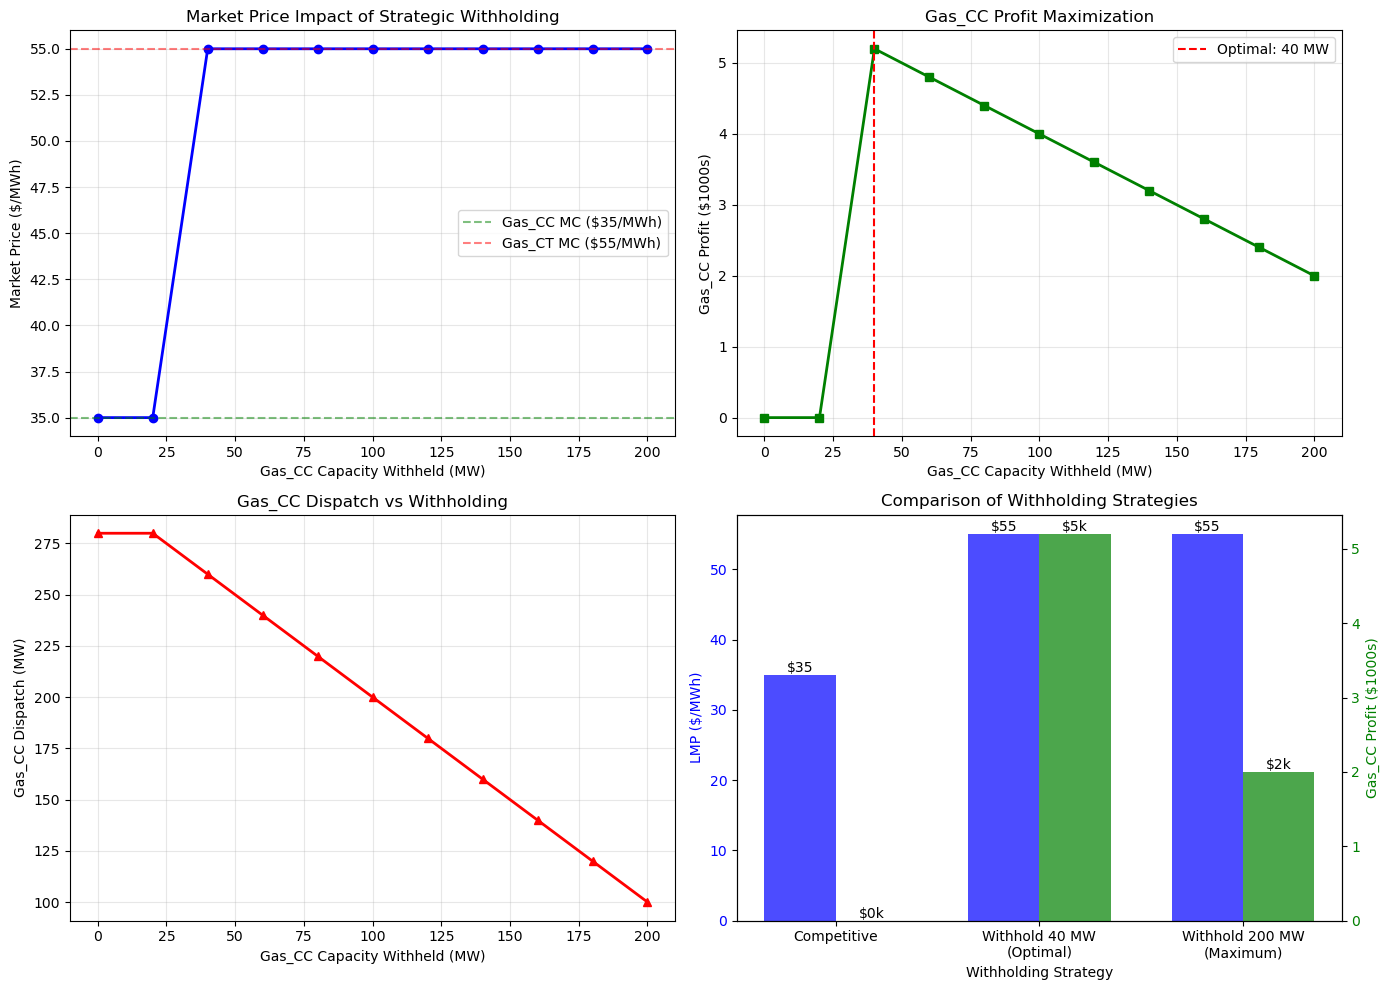

In [65]:
# Visualization of market power dynamics
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
withholding = [r['withhold'] for r in strategic_results]
lmps = [r['lmp'] for r in strategic_results]
profits = [r['profit'] for r in strategic_results]
dispatches = [r['dispatch'] for r in strategic_results]

# Create figure with subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: LMP vs Withholding
ax1.plot(withholding, lmps, 'b-', linewidth=2, marker='o', markersize=6)
ax1.axhline(y=35, color='green', linestyle='--', alpha=0.5, label='Gas_CC MC ($35/MWh)')
ax1.axhline(y=55, color='red', linestyle='--', alpha=0.5, label='Gas_CT MC ($55/MWh)')
ax1.set_xlabel('Gas_CC Capacity Withheld (MW)')
ax1.set_ylabel('Market Price ($/MWh)')
ax1.set_title('Market Price Impact of Strategic Withholding')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Profit vs Withholding
ax2.plot(withholding, [p/1000 for p in profits], 'g-', linewidth=2, marker='s', markersize=6)
ax2.axvline(x=optimal['withhold'], color='red', linestyle='--', 
            label=f"Optimal: {optimal['withhold']} MW")
ax2.set_xlabel('Gas_CC Capacity Withheld (MW)')
ax2.set_ylabel('Gas_CC Profit ($1000s)')
ax2.set_title('Gas_CC Profit Maximization')
ax2.grid(True, alpha=0.3)
ax2.legend()

# Plot 3: Dispatch vs Withholding
ax3.plot(withholding, dispatches, 'r-', linewidth=2, marker='^', markersize=6)
ax3.set_xlabel('Gas_CC Capacity Withheld (MW)')
ax3.set_ylabel('Gas_CC Dispatch (MW)')
ax3.set_title('Gas_CC Dispatch vs Withholding')
ax3.grid(True, alpha=0.3)

# Plot 4: Economic Impact Summary
categories = ['Competitive', f'Withhold {optimal["withhold"]} MW\n(Optimal)', 
               f'Withhold {withholding[-1]} MW\n(Maximum)']
lmp_values = [strategic_results[0]['lmp'], optimal['lmp'], strategic_results[-1]['lmp']]
profit_values = [strategic_results[0]['profit']/1000, optimal['profit']/1000, 
                 strategic_results[-1]['profit']/1000]

x = np.arange(len(categories))
width = 0.35

bars1 = ax4.bar(x - width/2, lmp_values, width, label='LMP ($/MWh)', color='blue', alpha=0.7)
ax4_twin = ax4.twinx()
bars2 = ax4_twin.bar(x + width/2, profit_values, width, label='Profit ($1000s)', color='green', alpha=0.7)

ax4.set_xlabel('Withholding Strategy')
ax4.set_ylabel('LMP ($/MWh)', color='blue')
ax4_twin.set_ylabel('Gas_CC Profit ($1000s)', color='green')
ax4.set_title('Comparison of Withholding Strategies')
ax4.set_xticks(x)
ax4.set_xticklabels(categories)
ax4.tick_params(axis='y', labelcolor='blue')
ax4_twin.tick_params(axis='y', labelcolor='green')

# Add value labels on bars
for bar, val in zip(bars1, lmp_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'${val:.0f}', ha='center', va='bottom')

for bar, val in zip(bars2, profit_values):
    height = bar.get_height()
    ax4_twin.text(bar.get_x() + bar.get_width()/2., height,
                  f'${val:.0f}k', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Exercise 5: Market Power Detection and Mitigation

This exercise investigates market vulnerability to strategic behavior and explores potential mitigation measures. Understanding when generators have market power is crucial for designing effective market rules and monitoring systems.

#### Part A: Pivotal Supplier Analysis

First, you'll identify which generators are "pivotal" - essential to meet demand. A generator is pivotal when the system cannot meet demand without its capacity. Calculate the pivotal threshold for each generator by determining at what demand level the remaining system capacity becomes insufficient. Observe how more generators become pivotal as demand increases, expanding opportunities for exercising market power.

**Hint:** For each generator, calculate the remaining system capacity if that generator were unavailable. If this remaining capacity is less than demand, the generator is pivotal. The pivotal threshold is the demand level where remaining capacity exactly equals demand.

In [66]:
# Exercise 5 Solution - Part A

def pivotal_supplier_test(generators, demand):
    """
    Test if any generator is pivotal (essential to meet demand)
    """
    results = {}
    total_capacity = sum(generators['p_max'])
    
    for name in generators['names']:
        idx = generators['names'].index(name)
        capacity = generators['p_max'][idx]
        remaining_capacity = total_capacity - capacity
        
        # Generator is pivotal if remaining capacity < demand
        is_pivotal = remaining_capacity < demand
        residual_demand = max(0, demand - remaining_capacity)
        
        results[name] = {
            'capacity': capacity,
            'remaining_capacity': remaining_capacity,
            'is_pivotal': is_pivotal,
            'residual_demand': residual_demand
        }
    
    return results

# Test at different demand levels
test_demands = [350, 400, 450, 500, 550]

print("=== Pivotal Supplier Analysis ===\n")
print(f"Total System Capacity: {sum(generators['p_max'])} MW\n")

pivotal_threshold = {}
for name in generators['names']:
    pivotal_threshold[name] = None

for demand in test_demands:
    pivotal_results = pivotal_supplier_test(generators, demand)
    pivotal_count = sum(1 for r in pivotal_results.values() if r['is_pivotal'])
    
    print(f"Demand: {demand} MW")
    for name, result in pivotal_results.items():
        if result['is_pivotal']:
            print(f"  {name} is PIVOTAL (without it, only {result['remaining_capacity']} MW available)")
            if pivotal_threshold[name] is None:
                pivotal_threshold[name] = demand
    
    if pivotal_count == 0:
        print(f"  No pivotal suppliers")
    print()

print("\nPivotal Threshold Summary:")
for name, threshold in pivotal_threshold.items():
    if threshold:
        print(f"{name} becomes pivotal at demand ≥ {threshold} MW")
    else:
        print(f"{name} is never pivotal in tested range")

print("\nMarket Power Implications:")
print("- Pivotal suppliers can raise prices knowing the system needs their capacity")
print("- Non-pivotal suppliers face competition and have limited market power")
print("- As demand increases, more generators become pivotal, increasing market power potential")

=== Pivotal Supplier Analysis ===

Total System Capacity: 650 MW

Demand: 350 MW
  No pivotal suppliers

Demand: 400 MW
  Gas_CC is PIVOTAL (without it, only 350 MW available)

Demand: 450 MW
  Gas_CC is PIVOTAL (without it, only 350 MW available)

Demand: 500 MW
  Coal is PIVOTAL (without it, only 450 MW available)
  Gas_CC is PIVOTAL (without it, only 350 MW available)

Demand: 550 MW
  Coal is PIVOTAL (without it, only 450 MW available)
  Gas_CC is PIVOTAL (without it, only 350 MW available)
  Gas_CT is PIVOTAL (without it, only 500 MW available)


Pivotal Threshold Summary:
Coal becomes pivotal at demand ≥ 500 MW
Gas_CC becomes pivotal at demand ≥ 400 MW
Gas_CT becomes pivotal at demand ≥ 550 MW

Market Power Implications:
- Pivotal suppliers can raise prices knowing the system needs their capacity
- Non-pivotal suppliers face competition and have limited market power
- As demand increases, more generators become pivotal, increasing market power potential


#### Part B: Market Power Mitigation Strategy

Based on your strategic withholding analysis, design a market power mitigation rule. Consider how limiting withholding when generators are pivotal could improve market outcomes while still allowing legitimate operational flexibility. Calculate the consumer savings from your proposed mitigation approach and discuss potential unintended consequences.

**Hint:** A common mitigation approach limits how much capacity pivotal suppliers can withhold. For example, requiring pivotal suppliers to offer at least 90% of their available capacity prevents extreme withholding while allowing for legitimate maintenance needs. Compare market outcomes with and without this rule to quantify consumer benefits.

In [67]:
# Exercise 5 Solution - Part B

print("\n=== Market Power Mitigation Analysis ===\n")

# Proposed mitigation: Limit withholding when generator is pivotal
print("Proposed Mitigation Rule:")
print("When a generator is pivotal, it must offer at least 90% of its available capacity")
print("This prevents extreme physical withholding while allowing for legitimate outages\n")

# Test the mitigation at high demand (480 MW)
demand_mit = 480
pivotal_test = pivotal_supplier_test(generators, demand_mit)

# Original market power scenario
withhold_original = {'Gas_CC': 150}  # Original aggressive withholding
result_original = analyze_market_power(generators, demand_mit, withhold_original)

# Mitigated scenario - limit withholding to 10% for pivotal suppliers
withhold_mitigated = {}
for name in generators['names']:
    if pivotal_test[name]['is_pivotal']:
        idx = generators['names'].index(name)
        max_withhold = 0.1 * generators['p_max'][idx]  # 10% of capacity
        if name in withhold_original:
            withhold_mitigated[name] = min(withhold_original[name], max_withhold)
            print(f"{name} is pivotal - withholding limited from {withhold_original[name]} MW to {withhold_mitigated[name]:.0f} MW")

result_mitigated = analyze_market_power(generators, demand_mit, withhold_mitigated)

# Calculate consumer savings
price_reduction = result_original['market_results']['lmp'] - result_mitigated['market_results']['lmp']
consumer_savings = demand_mit * price_reduction

print(f"\nMitigation Impact:")
print(f"Original LMP: ${result_original['market_results']['lmp']:.2f}/MWh")
print(f"Mitigated LMP: ${result_mitigated['market_results']['lmp']:.2f}/MWh")
print(f"Price Reduction: ${price_reduction:.2f}/MWh")
print(f"Consumer Savings: ${consumer_savings:,.2f}")

# Calculate impact on generator profits
gas_cc_idx = generators['names'].index('Gas_CC')
gas_cc_mc = generators['mc'][gas_cc_idx]

# Original profit
orig_dispatch = result_original['market_results']['dispatch']['Gas_CC']
orig_profit = orig_dispatch * (result_original['market_results']['lmp'] - gas_cc_mc)

# Mitigated profit
mit_dispatch = result_mitigated['market_results']['dispatch']['Gas_CC']
mit_profit = mit_dispatch * (result_mitigated['market_results']['lmp'] - gas_cc_mc)

print(f"\nImpact on Gas_CC:")
print(f"Profit reduction: ${orig_profit - mit_profit:,.2f}")
print(f"This represents a {(orig_profit - mit_profit)/orig_profit*100:.1f}% decrease in profit")


=== Market Power Mitigation Analysis ===

Proposed Mitigation Rule:
When a generator is pivotal, it must offer at least 90% of its available capacity
This prevents extreme physical withholding while allowing for legitimate outages

Gas_CC is pivotal - withholding limited from 150 MW to 30 MW

Mitigation Impact:
Original LMP: $55.00/MWh
Mitigated LMP: $55.00/MWh
Price Reduction: $0.00/MWh
Consumer Savings: $0.00

Impact on Gas_CC:
Profit reduction: $-2,400.00
This represents a -80.0% decrease in profit


## Summary

This lesson demonstrated how optimization techniques translate physical system constraints into economic signals in competitive electricity markets.

### Key Concepts

You learned how markets evolved from regulated utilities to competitive systems where optimization serves social welfare maximization rather than cost minimization. LMPs emerge from power balance constraint dual variables, creating price signals for efficient operation. Network constraints cause LMP separation when transmission limits bind, reflecting the economic value of scarce transmission capacity.

Multi-settlement markets balance planning certainty with operational flexibility through day-ahead and real-time markets, incentivizing accurate forecasting. Co-optimization efficiently allocates generation between energy and ancillary services by solving both markets simultaneously. Market power remains a concern due to demand inelasticity and transmission constraints, requiring careful monitoring through metrics like the Lerner Index and pivotal supplier analysis.

### Practical Skills

You can now implement market clearing algorithms with PuLP, analyze LMP formation and separation, model multi-settlement systems, co-optimize energy and reserves, and detect market power through pivotal supplier analysis and strategic withholding assessment.

### Next Steps

The next lesson applies these concepts to unit commitment, AC optimal power flow, and network-constrained market clearing. While market mechanisms continue evolving with renewable integration, the optimization principles you've learned remain fundamental to understanding electricity market design and operation.